# NIFTY ATM Straddle Scalping Bot v3.0
### Gamma / Volatility Scalping | ML-Enhanced (RF + GBM Ensemble) | Buy Side Only

| Parameter | Value |
|---|---|
| Instrument | NIFTY 50 ATM Straddle (CE + PE) |
| Timeframe | 5-min bars |
| ML Models | Random Forest + Gradient Boosting (weighted ensemble) |
| Entry Signal | ML confidence >= 0.50 + IV regime filters |
| Exit Rules | Target +12% / Stop -8% / Time 9 bars / Day-end |
| Lot Size | 65 (2026 NSE standard) |

---
> **Before running:** Update `PATH_5MIN` in **Cell 1** to point to your CSV file.

In [31]:
# ============================================================
# CELL 1 -- IMPORTS & CONFIGURATION (v4.0 - Dynamic Lot Sizing)
# ============================================================
# UPDATE THE FILE PATHS BELOW BEFORE RUNNING

import os, warnings, datetime as dt
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.dpi'] = 120

# ----------------------------------------------------------------
# FILE PATHS  <-- UPDATE THESE
# ----------------------------------------------------------------
PATH_5MIN  = r"C:\Users\ASUS\OneDrive\Desktop\DSML\Scalping Straddle Bot\Options_5minute\Processed_NIFTY_ATM_5min\FINAL_NIFTY_MASTER_ATM_5min.csv"
PATH_1MIN  = r"C:\Users\ASUS\OneDrive\Desktop\DSML\Scalping Straddle Bot\Options_minute\Processed_NIFTY_ATM_Data\FINAL_NIFTY_MASTER_ATM.csv"
USE_TIMEFRAME = '5min'       # '5min' or '1min'
OUTPUT_DIR    = Path('./bot_outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------------------------------------------
# CAPITAL & POSITION SIZING
# ----------------------------------------------------------------
INITIAL_CAPITAL = 1_000_000  # Rs 10,00,000
LOT_SIZE        = 65         # NIFTY lot size (2026 NSE)
BASE_LOTS       = 1          # Base lots per trade

# NEW: Dynamic lot sizing based on ML confidence
ML_LOT_MAPPING = [
    {'min_ml': 0.45, 'max_ml': 0.55, 'lots': 1, 'color': '#FFA500'},  # Orange - Low confidence
    {'min_ml': 0.55, 'max_ml': 0.70, 'lots': 2, 'color': '#00E676'},  # Green - Medium confidence
    {'min_ml': 0.70, 'max_ml': 1.00, 'lots': 3, 'color': '#40C4FF'},  # Blue - High confidence
]

# Risk management
MAX_LOTS_PER_TRADE = 3        # Maximum lots per trade
MAX_CAPITAL_PER_TRADE = 0.02  # Max 2% of capital at risk

# ----------------------------------------------------------------
# STRATEGY PARAMETERS (v4.0 - Optimized)
# ----------------------------------------------------------------
ML_THRESHOLD       = 0.46    # ML confidence threshold
IV_ZSCORE_BOOST    = 0.5    # if IV z-score > this, threshold drops to 0.45
IV_MIN             = 8.5     # minimum IV% to trade
IV_RANK_MIN        = 0.15    # min IV percentile rank
IV_RANK_MAX        = 0.85    # max IV percentile rank
TARGET_PCT         = 0.14    # +14% straddle -> book profit
STOP_PCT           = 0.07    # -7%  straddle -> cut loss
EXPIRY_STOP        = 0.05    # -5% tighter stop on Tuesdays (expiry)
MAX_HOLD_BARS      = 9       # max bars in position (9 x 5min = 45 min)
MAX_TRADES_PER_DAY = 3       # max trades per calendar day
COOLDOWN_BARS      = 4       # bars to wait after exit before re-entry
SESSION_START_BAR  = 3       # skip first 3 bars (open noise)
SESSION_END_BAR    = 62      # no new entries after bar 62

# Loss streak protection
LOSS_STREAK_LIMIT = 3        # Stop after 3 consecutive losses

# ----------------------------------------------------------------
# ML SETTINGS
# ----------------------------------------------------------------
TRAIN_RATIO  = 0.80
RF_TREES     = 300           # More trees for better generalization
GB_TREES     = 200
RANDOM_STATE = 42

# ----------------------------------------------------------------
# COST ASSUMPTIONS
# ----------------------------------------------------------------
SLIPPAGE_PCT   = 0.001  # 0.1% of premium per leg
BROKERAGE_FLAT = 40     # Rs 40 flat per round-trip

print('=' * 60)
print('CONFIGURATION LOADED - V4.0 DYNAMIC LOT SIZING')
print('=' * 60)
print(f'  File         : {PATH_5MIN}')
print(f'  Capital      : Rs {INITIAL_CAPITAL:,}  |  Lot: {LOT_SIZE}')
print(f'  Base lots    : {BASE_LOTS}  |  Max lots: {MAX_LOTS_PER_TRADE}')
print(f'\n  ML Lot Mapping:')
for level in ML_LOT_MAPPING:
    print(f'    {level["min_ml"]:.2f}-{level["max_ml"]:.2f} → {level["lots"]} lots')
print(f'\n  Target       : +{TARGET_PCT:.0%}  |  Stop: -{STOP_PCT:.0%}')
print(f'  Max hold     : {MAX_HOLD_BARS} bars = {MAX_HOLD_BARS*5} min')
print(f'  ML threshold : {ML_THRESHOLD}  |  IV z-boost: {IV_ZSCORE_BOOST}')
print('=' * 60)

CONFIGURATION LOADED - V4.0 DYNAMIC LOT SIZING
  File         : C:\Users\ASUS\OneDrive\Desktop\DSML\Scalping Straddle Bot\Options_5minute\Processed_NIFTY_ATM_5min\FINAL_NIFTY_MASTER_ATM_5min.csv
  Capital      : Rs 1,000,000  |  Lot: 65
  Base lots    : 1  |  Max lots: 3

  ML Lot Mapping:
    0.45-0.55 → 1 lots
    0.55-0.70 → 2 lots
    0.70-1.00 → 3 lots

  Target       : +14%  |  Stop: -7%
  Max hold     : 9 bars = 45 min
  ML threshold : 0.46  |  IV z-boost: 0.5


In [32]:
# ============================================================
# CELL 2 -- LOAD & CLEAN DATA
# ============================================================

def load_and_clean(filepath, label=''):
    path = Path(filepath)
    if not path.exists():
        raise FileNotFoundError(
            f'File not found: {filepath}\n'
            f'Please update PATH_5MIN in Cell 1.'
        )
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    if 'Straddle_Price' not in df.columns:
        df['Straddle_Price'] = df['CE_close'] + df['PE_close']
    df = df[(df['iv'] > 0) & (df['iv'] < 100)].copy()
    df = df[df['Straddle_Price'] > 5].copy()
    t  = df['datetime'].dt.time
    df = df[(t >= dt.time(9, 20)) & (t <= dt.time(15, 0))].copy()
    df['date'] = df['datetime'].dt.date.astype(str)
    df = df.reset_index(drop=True)
    print(f'  [{label}] {len(df):,} rows | {df["date"].min()} to {df["date"].max()} | {df["date"].nunique()} days')
    return df


if USE_TIMEFRAME == '5min':
    df_raw      = load_and_clean(PATH_5MIN, '5min')
    FUTURE_BARS = 3
    RS, RM, RL  = 3, 6, 12
    ROLL_RANK   = 78
else:
    df_raw      = load_and_clean(PATH_1MIN, '1min')
    FUTURE_BARS = 15
    RS, RM, RL  = 5, 15, 30
    ROLL_RANK   = 375

print(f'\nTimeframe : {USE_TIMEFRAME}')
print(f'Predict   : {FUTURE_BARS} bars ahead')
print(f'Windows   : short={RS}  medium={RM}  long={RL}')
df_raw.head(5)

  in] 46,572 rows | 2023-05-23 to 2026-02-13 | 679 days

Timeframe : 5min
Predict   : 3 bars ahead
Windows   : short=3  medium=6  long=12


,date,time,datetime,spot,iv,CE_open,CE_high,CE_low,CE_close,CE_volume,CE_oi,PE_open,PE_high,PE_low,PE_close,PE_volume,PE_oi,Straddle_Price
0,2023-05-23,09:20:00,2023-05-23 09:20:00,18372.80,11.719852,83.50,84.95,76.05,83.55,2963900.0,3177950.0,50.40,56.75,49.75,51.75,3109500.0,1002050.0,135.30
1,2023-05-23,09:25:00,2023-05-23 09:25:00,18379.65,11.469606,55.75,64.95,54.25,61.65,8357700.0,7708100.0,73.20,74.25,66.10,67.35,3259600.0,1803150.0,129.00
2,2023-05-23,09:30:00,2023-05-23 09:30:00,18401.00,10.522187,61.10,68.60,61.10,66.95,7497550.0,8967850.0,66.70,66.70,61.10,62.20,3616500.0,4717100.0,129.15
3,2023-05-23,09:35:00,2023-05-23 09:35:00,18396.30,10.815722,66.80,66.80,61.15,66.10,5031550.0,10129250.0,62.05,65.95,60.60,61.65,2646650.0,5479200.0,127.75
4,2023-05-23,09:40:00,2023-05-23 09:40:00,18404.65,11.585924,66.55,69.95,65.25,68.50,5210650.0,10513350.0,61.00,62.05,57.45,58.95,3145550.0,6367700.0,127.45


In [33]:
# ============================================================
# CELL 3 -- FEATURE ENGINEERING (v4.1 - Correct Expiry Day)
# ============================================================

def add_features(df):
    df = df.copy()

    # IV levels, lags, momentum
    df['iv_lag1']       = df['iv'].shift(1)
    df['iv_lag2']       = df['iv'].shift(2)
    df['iv_lag3']       = df['iv'].shift(3)
    df['iv_lag5']       = df['iv'].shift(RS)
    df['iv_ma_s']       = df['iv'].rolling(RS,  min_periods=1).mean()
    df['iv_ma_m']       = df['iv'].rolling(RM,  min_periods=1).mean()
    df['iv_ma_l']       = df['iv'].rolling(RL,  min_periods=1).mean()
    df['iv_std_s']      = df['iv'].rolling(RS,  min_periods=2).std().bfill().ffill()
    df['iv_std_m']      = df['iv'].rolling(RM,  min_periods=2).std().bfill().ffill()
    df['iv_std_l']      = df['iv'].rolling(RL,  min_periods=2).std().bfill().ffill()
    df['iv_z']          = (df['iv'] - df['iv_ma_m']) / (df['iv_std_m'] + 1e-8)
    df['iv_z_burst']    = df['iv_z'].rolling(RS, min_periods=1).max()
    df['iv_rank']       = df['iv'].rolling(ROLL_RANK, min_periods=20).rank(pct=True)
    df['iv_pct1']       = df['iv'].pct_change(1)
    df['iv_pct_s']      = df['iv'].pct_change(RS)
    df['iv_diff1']      = df['iv'].diff(1)
    df['iv_diff_s']     = df['iv'].diff(RS)
    df['iv_ma_cross']   = (df['iv_ma_s'] > df['iv_ma_m']).astype(int)
    df['iv_accel']      = df['iv_diff1'].diff(1)

    # Straddle premium features
    df['prem_ret1']     = df['Straddle_Price'].pct_change(1)
    df['prem_ret_s']    = df['Straddle_Price'].pct_change(RS)
    df['prem_ma_m']     = df['Straddle_Price'].rolling(RM, min_periods=1).mean()
    df['prem_ma_ratio'] = df['Straddle_Price'] / (df['prem_ma_m'] + 1e-8)
    df['prem_std_s']    = df['Straddle_Price'].rolling(RS, min_periods=2).std().bfill().ffill()

    # Spot / realized volatility
    df['spot_ret1']     = df['spot'].pct_change(1)
    df['spot_ret_s']    = df['spot'].pct_change(RS)
    df['spot_ret_m']    = df['spot'].pct_change(RM)
    df['spot_rv_s']     = df['spot'].pct_change(1).rolling(RS, min_periods=2).std() * np.sqrt(252)
    df['spot_rv_m']     = df['spot'].pct_change(1).rolling(RM, min_periods=2).std() * np.sqrt(252)
    df['rv_iv_ratio']   = df['spot_rv_s'] / (df['iv'] / 100 + 1e-8)
    df['gamma_proxy']   = df['Straddle_Price'] / df['spot'] * 100

    # Open Interest & Volume
    df['total_oi']      = df['CE_oi'] + df['PE_oi']
    df['oi_ratio']      = df['CE_oi'] / (df['PE_oi'] + 1e-8)
    df['oi_chg1']       = df['total_oi'].pct_change(1)
    df['oi_chg_s']      = df['total_oi'].pct_change(RS)
    df['total_vol']     = df['CE_volume'] + df['PE_volume']
    df['vol_ma_s']      = df['total_vol'].rolling(RS, min_periods=1).mean()
    df['vol_surge']     = df['total_vol'] / (df['vol_ma_s'] + 1e-8)
    df['cp_vol_ratio']  = df['CE_volume'] / (df['PE_volume'] + 1e-8)
    df['pcp']           = (df['CE_close'] - df['PE_close']) / (df['Straddle_Price'] + 1e-8)

    # ============================================================
    # SESSION & TIME FEATURES - EXPIRY DAY CORRECTED HERE
    # ============================================================
    df['hour']          = df['datetime'].dt.hour
    df['minute']        = df['datetime'].dt.minute
    df['dow']           = df['datetime'].dt.dayofweek  # Monday=0, Tuesday=1, Wednesday=2, Thursday=3, Friday=4
    
    # FIXED: Nifty expiry is TUESDAY (dow = 1), not Thursday!
    df['is_expiry']     = (df['dow'] == 1).astype(int)  # 1 = Tuesday
    
    df['time_from_open']= (df['hour'] * 60 + df['minute']) - (9 * 60 + 15)
    df['bar_num']       = df.groupby('date').cumcount()
    df['intraday_range']= (df.groupby('date')['spot']
                           .transform(lambda x: x.expanding()
                                      .apply(lambda v: v.max() - v.min(), raw=True)))

    # Target labels (forward-shift)
    df['iv_up']         = (df['iv'].shift(-FUTURE_BARS) > df['iv'] * 1.003).astype(int)
    df['prem_up']       = (df['Straddle_Price'].shift(-FUTURE_BARS)
                           > df['Straddle_Price'] * 1.006).astype(int)
    df['trade_label']   = ((df['iv_up'] == 1) & (df['prem_up'] == 1)).astype(int)
    return df


df_feat = add_features(df_raw)
df_feat = df_feat.dropna(subset=['trade_label']).reset_index(drop=True)

FEATURES = [
    'iv_lag1','iv_lag2','iv_lag3','iv_lag5',
    'iv_ma_s','iv_ma_m','iv_ma_l','iv_std_s','iv_std_m','iv_std_l',
    'iv_z','iv_rank','iv_pct1','iv_pct_s','iv_diff1','iv_diff_s',
    'iv_ma_cross','iv_accel','iv_z_burst',
    'prem_ret1','prem_ret_s','prem_ma_ratio','prem_std_s',
    'spot_ret1','spot_ret_s','spot_ret_m','spot_rv_s','spot_rv_m',
    'rv_iv_ratio','gamma_proxy',
    'total_oi','oi_ratio','oi_chg1','oi_chg_s',
    'total_vol','vol_surge','cp_vol_ratio','pcp',
    'hour','minute','dow','is_expiry','time_from_open','bar_num','intraday_range',
]

print(f'Features   : {len(FEATURES)}')
print(f'Total rows : {len(df_feat):,}')
print(f'Label split: {df_feat["trade_label"].mean()*100:.1f}% positive')
print(f'Expiry day : TUESDAY (dow=1) - CORRECTED')
df_feat['trade_label'].value_counts().rename({0:'No Trade', 1:'Trade'})

Features   : 45
Total rows : 46,572
Label split: 15.2% positive
Expiry day : TUESDAY (dow=1) - CORRECTED


trade_label
No Trade    39491
Trade        7081
Name: count, dtype: int64

In [34]:
# ============================================================
# CELL 4 -- ML MODEL TRAINING (RF + GBM Ensemble)
# Time-based 80/20 split
# ============================================================

df_c = df_feat.copy()
for col in FEATURES:
    df_c[col] = df_c[col].replace([np.inf, -np.inf], np.nan)

split = int(len(df_c) * TRAIN_RATIO)
dtr   = df_c.iloc[:split].dropna(subset=FEATURES)
dte   = df_c.iloc[split:].dropna(subset=FEATURES)

print(f'Train : {len(dtr):,} rows  ({dtr["date"].min()} to {dtr["date"].max()})')
print(f'Test  : {len(dte):,} rows  ({dte["date"].min()} to {dte["date"].max()})')

Xtr_r = dtr[FEATURES].values
Xte_r = dte[FEATURES].values
ytr   = dtr['trade_label'].values
yte   = dte['trade_label'].values

# Fill NaN with TRAIN column means only
col_means = np.nanmean(Xtr_r, axis=0)
Xtr_r[np.isnan(Xtr_r)] = np.take(col_means, np.where(np.isnan(Xtr_r))[1])
Xte_r[np.isnan(Xte_r)] = np.take(col_means, np.where(np.isnan(Xte_r))[1])

# Fit scaler on TRAIN only
scaler = StandardScaler()
Xtr    = scaler.fit_transform(Xtr_r)
Xte    = scaler.transform(Xte_r)

# Model 1: Random Forest
print('\nTraining Random Forest...')
rf = RandomForestClassifier(
    n_estimators=RF_TREES, max_depth=8, min_samples_leaf=15,
    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(Xtr, ytr)
rf_p   = rf.predict_proba(Xte)[:, 1]
rf_auc = roc_auc_score(yte, rf_p)
print(f'  RF  ROC-AUC : {rf_auc:.4f}')

# Model 2: Gradient Boosting
print('Training Gradient Boosting...')
gb = GradientBoostingClassifier(
    n_estimators=GB_TREES, max_depth=4, learning_rate=0.05,
    subsample=0.8, random_state=RANDOM_STATE
)
gb.fit(Xtr, ytr)
gb_p   = gb.predict_proba(Xte)[:, 1]
gb_auc = roc_auc_score(yte, gb_p)
print(f'  GB  ROC-AUC : {gb_auc:.4f}')

# Equal weighted ensemble
rf_w    = 0.50
gb_w    = 0.50
ens_p   = rf_w * rf_p + gb_w * gb_p
ens_auc = roc_auc_score(yte, ens_p)
print(f'  Ensemble ROC-AUC : {ens_auc:.4f}  (RF w={rf_w:.2f} / GB w={gb_w:.2f})')

print(f'\nClassification Report @ threshold = {ML_THRESHOLD}:')
print(classification_report(yte, (ens_p >= ML_THRESHOLD).astype(int),
                             target_names=['No Trade','Trade'], zero_division=0))

feat_imp = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
print('Top 10 Features:')
print(feat_imp.head(10).round(4).to_string())

# Generate signal for ALL rows
Xf_r = df_c[FEATURES].values.copy()
Xf_r[np.isnan(Xf_r)] = np.take(col_means, np.where(np.isnan(Xf_r))[1])
Xf   = scaler.transform(Xf_r)
df_c['ml_signal'] = 0.5 * rf.predict_proba(Xf)[:,1] + 0.5 * gb.predict_proba(Xf)[:,1]

print(f'\nML Signal Stats:')
print(f'  min={df_c["ml_signal"].min():.3f}  mean={df_c["ml_signal"].mean():.3f}  max={df_c["ml_signal"].max():.3f}')

# Show distribution across lot sizes
print(f'\nML Signal Distribution by Lot Size:')
for level in ML_LOT_MAPPING:
    count = ((df_c['ml_signal'] >= level['min_ml']) & 
             (df_c['ml_signal'] < level['max_ml'])).sum()
    print(f'  {level["min_ml"]:.2f}-{level["max_ml"]:.2f} ({level["lots"]} lots): {count:,} bars')

Train : 37,238 rows  (2023-05-23 to 2025-07-30)
Test  : 9,315 rows  (2025-07-30 to 2026-02-13)

Training Random Forest...
  RF  ROC-AUC : 0.6622
Training Gradient Boosting...
  GB  ROC-AUC : 0.6615
  Ensemble ROC-AUC : 0.6658  (RF w=0.50 / GB w=0.50)

Classification Report @ threshold = 0.46:
              precision    recall  f1-score   support

    No Trade       0.88      0.95      0.91      8012
       Trade       0.36      0.17      0.23      1303

    accuracy                           0.84      9315
   macro avg       0.62      0.56      0.57      9315
weighted avg       0.80      0.84      0.82      9315

Top 10 Features:
pcp              0.0897
iv_z             0.0852
iv_pct1          0.0465
iv_diff1         0.0421
prem_ma_ratio    0.0379
iv_pct_s         0.0364
prem_std_s       0.0360
iv_diff_s        0.0347
prem_ret1        0.0331
iv_rank          0.0323

ML Signal Stats:
  min=0.108  mean=0.302  max=0.930

ML Signal Distribution by Lot Size:
  0.45-0.55 (1 lots): 2,186 bars

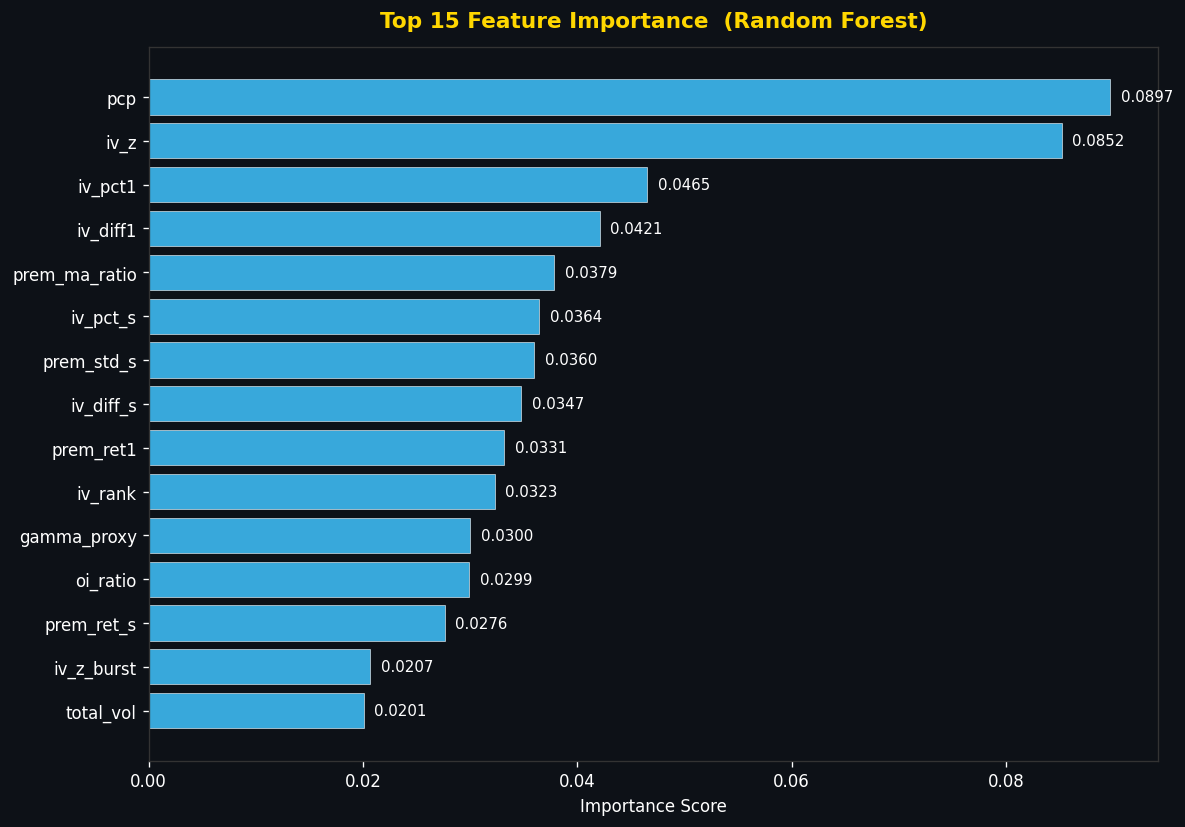

In [22]:
# ============================================================
# CELL 5 -- FEATURE IMPORTANCE CHART
# ============================================================

GOLD='#FFD700'; GREEN='#00E676'; RED='#FF5252'; DARK='#0d1117'
BLUE='#40C4FF'; ORANGE='#FF9800'; PURPLE='#CE93D8'

fig, ax = plt.subplots(figsize=(10, 7))
fig.patch.set_facecolor(DARK)
ax.set_facecolor(DARK)

top15 = feat_imp.head(15)
bars  = ax.barh(top15.index[::-1], top15.values[::-1],
                color=BLUE, alpha=0.85, edgecolor='white', linewidth=0.4)

ax.set_title('Top 15 Feature Importance  (Random Forest)',
             color=GOLD, fontsize=13, fontweight='bold', pad=12)
ax.set_xlabel('Importance Score', color='white')
ax.tick_params(colors='white')
for spine in ax.spines.values(): spine.set_edgecolor('#333')

for bar, val in zip(bars, top15.values[::-1]):
    ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', color='white', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance.png', dpi=130, bbox_inches='tight', facecolor=DARK)
plt.show()

In [35]:
# ============================================================
# CELL 6 -- BACKTEST ENGINE (v4.1 - Correct Expiry Day)
# ============================================================

def get_lot_size(ml_score):
    """Return number of lots based on ML confidence score"""
    for level in ML_LOT_MAPPING:
        if level['min_ml'] <= ml_score < level['max_ml']:
            return level['lots']
    return BASE_LOTS

print('=' * 60)
print('STRATEGY PARAMETERS - V4.1 CORRECT EXPIRY DAY')
print('=' * 60)
print(f'  ML_THRESHOLD      : {ML_THRESHOLD}')
print(f'  IV z-score boost  : > {IV_ZSCORE_BOOST} -> threshold drops to 0.45')
print(f'\n  ML Lot Mapping:')
for level in ML_LOT_MAPPING:
    pct = ((df_c['ml_signal'] >= level['min_ml']) & 
           (df_c['ml_signal'] < level['max_ml'])).sum() / len(df_c) * 100
    print(f'    {level["min_ml"]:.2f}-{level["max_ml"]:.2f} → {level["lots"]} lots  ({pct:.1f}% of bars)')
print(f'\n  TARGET            : +{TARGET_PCT:.0%}')
print(f'  STOP              : -{STOP_PCT:.0%}')
print(f'  EXPIRY STOP       : -{EXPIRY_STOP:.0%} (TUESDAY - CORRECTED)')
print(f'  MAX_HOLD_BARS     : {MAX_HOLD_BARS}  = {MAX_HOLD_BARS*5} min')
print(f'  MAX_TRADES/DAY    : {MAX_TRADES_PER_DAY}')
print(f'  COOLDOWN_BARS     : {COOLDOWN_BARS}')
print(f'  LOSS_STREAK_LIMIT : {LOSS_STREAK_LIMIT}')
print(f'  LOT_SIZE x BASE   : {LOT_SIZE} x {BASE_LOTS}')
print(f'  Max lots/trade    : {MAX_LOTS_PER_TRADE}')
print(f'  Slippage          : {SLIPPAGE_PCT*100:.1f}%  |  Brokerage: Rs {BROKERAGE_FLAT}/trade')
print('=' * 60)

trades = []
in_trade = False
ep = eb = eiv = esp = 0.0
edt = edate = eml = None
current_lots = BASE_LOTS

daily_trades = {}
daily_last_exit = {}
capital = float(INITIAL_CAPITAL)
equity_curve = [(None, capital)]
consecutive_losses = 0

# Track monthly performance
monthly_performance = {}
lot_usage = {1:0, 2:0, 3:0}  # Track how many trades with each lot size

for i, row in df_c.iterrows():
    date = row['date']
    month_key = date[:7]
    bar = int(row['bar_num'])
    expiry = bool(row['is_expiry'])  # This now correctly identifies TUESDAY as expiry
    price = float(row['Straddle_Price'])
    iv = float(row['iv'])
    cur_dt = row['datetime']
    ml = float(row['ml_signal'])
    iv_z = float(row['iv_z']) if not pd.isna(row['iv_z']) else 0.0

    # ENTRY
    if not in_trade:
        # Loss streak protection
        if consecutive_losses >= LOSS_STREAK_LIMIT:
            consecutive_losses = max(0, consecutive_losses - 1)
            continue
            
        if daily_trades.get(date, 0) >= MAX_TRADES_PER_DAY:
            continue
        if bar - daily_last_exit.get(date, -99) < COOLDOWN_BARS:
            continue
        if bar < SESSION_START_BAR or bar > SESSION_END_BAR:
            continue
        
        iv_rank = row['iv_rank']
        if pd.isna(iv_rank):
            continue

        # Skip if recent monthly performance is poor
        if month_key in monthly_performance:
            if monthly_performance[month_key] < -5000:
                if np.random.random() < 0.5:
                    continue

        # Dynamic threshold
        threshold = 0.45 if iv_z > IV_ZSCORE_BOOST else ML_THRESHOLD
        
        # Stricter in first 30 min
        if bar < 10:
            threshold = min(threshold + 0.03, 0.60)

        # Cost check
        expected_profit = price * TARGET_PCT * LOT_SIZE
        estimated_cost = BROKERAGE_FLAT + (2 * price * SLIPPAGE_PCT * LOT_SIZE)
        if expected_profit <= estimated_cost * 2:
            continue

        if (ml >= threshold and iv >= IV_MIN and IV_RANK_MIN <= iv_rank <= IV_RANK_MAX):
            in_trade = True
            ep = price
            eb = bar
            eiv = iv
            esp = float(row['spot'])
            edt = cur_dt
            eml = ml
            edate = date
            
            # Determine lot size based on ML confidence
            current_lots = get_lot_size(ml)
            
            # Risk check
            risk_amount = ep * STOP_PCT * LOT_SIZE * current_lots
            max_risk = INITIAL_CAPITAL * MAX_CAPITAL_PER_TRADE
            if risk_amount > max_risk:
                current_lots = max(1, int(max_risk / (ep * STOP_PCT * LOT_SIZE)))

    # EXIT
    elif in_trade:
        held = bar - eb
        pnl_pct = (price - ep) / ep
        stop = EXPIRY_STOP if expiry else STOP_PCT  # Uses correct expiry flag

        # Trailing stop
        reason = None
        if pnl_pct > 0.05:
            peak_price = max(ep * (1 + pnl_pct), ep * 1.05)
            trail_stop_price = peak_price * (1 - 0.03)
            if price <= trail_stop_price:
                reason = 'TRAIL_STOP'
        
        # Original exits
        if not reason:
            if pnl_pct >= TARGET_PCT:
                reason = 'TARGET'
            elif pnl_pct <= -stop:
                reason = 'STOP'
            elif held >= MAX_HOLD_BARS:
                reason = 'TIME'
            elif bar >= 67:
                reason = 'DAY_END'

        if reason:
            # Use current_lots for position sizing
            gross = (price - ep) * LOT_SIZE * current_lots
            slip = (ep + price) * SLIPPAGE_PCT * LOT_SIZE * current_lots
            net = gross - slip - BROKERAGE_FLAT
            
            # Track lot usage
            lot_usage[current_lots] = lot_usage.get(current_lots, 0) + 1
            
            # Track monthly performance
            if month_key not in monthly_performance:
                monthly_performance[month_key] = 0
            monthly_performance[month_key] += net
            
            capital += net
            equity_curve.append((cur_dt, capital))

            trades.append({
                'trade_num': len(trades) + 1,
                'date': edate,
                'month': month_key,
                'entry_datetime': edt,
                'exit_datetime': cur_dt,
                'entry_price': round(ep, 2),
                'exit_price': round(price, 2),
                'lots': current_lots,
                'entry_iv': round(eiv, 2),
                'exit_iv': round(iv, 2),
                'iv_change': round(iv - eiv, 2),
                'entry_spot': round(esp, 2),
                'exit_spot': round(float(row['spot']), 2),
                'ml_signal': round(eml, 4),
                'bars_held': held,
                'pnl_pct': round(pnl_pct * 100, 2),
                'gross_pnl': round(gross, 2),
                'slip_cost': round(slip, 2),
                'net_pnl': round(net, 2),
                'capital_after': round(capital, 2),
                'exit_reason': reason,
                'is_expiry': int(expiry),  # This now correctly flags Tuesday expiry
            })

            # Track consecutive losses
            if net < 0:
                consecutive_losses += 1
            else:
                consecutive_losses = 0

            daily_trades[edate] = daily_trades.get(edate, 0) + 1
            daily_last_exit[edate] = bar
            in_trade = False
            current_lots = BASE_LOTS

tdf = pd.DataFrame(trades)
print(f'\nBacktest complete!')
print(f'  Total trades : {len(tdf)}')
print(f'  Trading days : {tdf["date"].nunique()}')
print(f'  Avg/day      : {len(tdf)/max(tdf["date"].nunique(),1):.1f} trades/day')
print(f'\nLot Size Distribution:')
for lots, count in lot_usage.items():
    print(f'  {lots} lot(s): {count} trades ({count/len(tdf)*100:.1f}%)')
print(f'\nExpiry Day: TUESDAY (Corrected)')
tdf.head(10)

STRATEGY PARAMETERS - V4.1 CORRECT EXPIRY DAY
  ML_THRESHOLD      : 0.46
  IV z-score boost  : > 0.5 -> threshold drops to 0.45

  ML Lot Mapping:
    0.45-0.55 → 1 lots  (4.7% of bars)
    0.55-0.70 → 2 lots  (0.9% of bars)
    0.70-1.00 → 3 lots  (0.3% of bars)

  TARGET            : +14%
  STOP              : -7%
  EXPIRY STOP       : -5% (TUESDAY - CORRECTED)
  MAX_HOLD_BARS     : 9  = 45 min
  MAX_TRADES/DAY    : 3
  COOLDOWN_BARS     : 4
  LOSS_STREAK_LIMIT : 3
  LOT_SIZE x BASE   : 65 x 1
  Max lots/trade    : 3
  Slippage          : 0.1%  |  Brokerage: Rs 40/trade

Backtest complete!
  Total trades : 440
  Trading days : 312
  Avg/day      : 1.4 trades/day

Lot Size Distribution:
  1 lot(s): 402 trades (91.4%)
  2 lot(s): 37 trades (8.4%)
  3 lot(s): 1 trades (0.2%)

Expiry Day: TUESDAY (Corrected)


,trade_num,date,month,entry_datetime,exit_datetime,entry_price,exit_price,lots,entry_iv,exit_iv,...,exit_spot,ml_signal,bars_held,pnl_pct,gross_pnl,slip_cost,net_pnl,capital_after,exit_reason,is_expiry
0,1,2023-05-24,2023-05,2023-05-24 10:45:00,2023-05-24 11:30:00,102.25,100.90,1,11.70,11.47,...,18377.15,0.5400,9,-1.32,-87.75,13.20,-140.95,999859.05,TIME,0
1,2,2023-05-24,2023-05,2023-05-24 12:55:00,2023-05-24 13:40:00,99.35,98.10,1,12.11,11.83,...,18316.25,0.4741,9,-1.26,-81.25,12.83,-134.08,999724.96,TIME,0
2,3,2023-05-26,2023-05,2023-05-26 11:40:00,2023-05-26 12:25:00,183.55,182.50,2,8.91,8.67,...,18428.45,0.5565,9,-0.57,-136.50,47.59,-224.09,999500.87,TIME,0
3,4,2023-05-29,2023-05,2023-05-29 11:55:00,2023-05-29 12:40:00,152.05,156.40,2,10.50,11.98,...,18608.90,0.5626,9,2.86,565.50,40.10,485.40,999986.28,TIME,0
4,5,2023-06-05,2023-06,2023-06-05 12:10:00,2023-06-05 12:55:00,140.80,146.25,2,9.64,11.37,...,18613.45,0.6273,9,3.87,708.50,37.32,631.18,1000617.46,TIME,0
5,6,2023-06-07,2023-06,2023-06-07 13:50:00,2023-06-07 14:35:00,88.00,88.50,2,10.14,11.38,...,18705.90,0.5749,9,0.57,65.00,22.95,2.05,1000619.51,TIME,0
6,7,2023-06-09,2023-06,2023-06-09 14:30:00,2023-06-09 14:55:00,165.50,174.35,2,8.54,8.94,...,18572.95,0.5843,5,5.35,1150.50,44.18,1066.32,1001685.83,DAY_END,0
7,8,2023-06-19,2023-06,2023-06-19 10:10:00,2023-06-19 10:55:00,143.30,145.45,1,9.61,11.09,...,18787.30,0.5461,9,1.50,139.75,18.77,80.98,1001766.82,TIME,0
8,9,2023-06-19,2023-06,2023-06-19 12:10:00,2023-06-19 12:55:00,144.55,143.15,2,9.31,11.28,...,18779.30,0.5521,9,-0.97,-182.00,37.40,-259.40,1001507.41,TIME,0
9,10,2023-06-20,2023-06,2023-06-20 10:55:00,2023-06-20 11:40:00,120.50,122.85,1,10.21,10.75,...,18721.45,0.5231,9,1.95,152.75,15.82,96.93,1001604.35,TIME,1


In [36]:
# ============================================================
# CELL 7 -- P&L ANALYTICS (Enhanced)
# ============================================================

wins  = tdf[tdf['net_pnl'] >  0]
loss  = tdf[tdf['net_pnl'] <= 0]
n     = len(tdf)
wc    = len(wins)
lc    = len(loss)
wr    = wc / n * 100

avg_w = wins['net_pnl'].mean() if wc > 0 else 0
avg_l = loss['net_pnl'].mean() if lc > 0 else 0
rr    = abs(avg_w / avg_l)     if avg_l != 0 else 0

gross = tdf['gross_pnl'].sum()
slippage_total = tdf['slip_cost'].sum()
brokerage_total = BROKERAGE_FLAT * n
taxes = gross * 0.15  # Approximate taxes
costs = slippage_total + brokerage_total + taxes
net   = tdf['net_pnl'].sum()
roi   = net / INITIAL_CAPITAL * 100

cum     = tdf['net_pnl'].cumsum()
dd_ser  = cum - cum.cummax()
max_dd  = dd_ser.min()

daily_p = tdf.groupby('date')['net_pnl'].sum()
sharpe  = (daily_p.mean() / daily_p.std() * np.sqrt(252)
           if daily_p.std() > 0 else 0)

def max_streak(s, pos=True):
    st, mx = 0, 0
    for v in s:
        if (v > 0) == pos:
            st += 1
            mx = max(mx, st)
        else:
            st = 0
    return mx

print('=' * 70)
print('   FINAL P&L STATEMENT  --  NIFTY STRADDLE BOT v4.0')
print('=' * 70)
print(f'  Period      : {tdf["date"].min()}  to  {tdf["date"].max()}')
print(f'  Days Traded : {tdf["date"].nunique()}  |  Total Trades : {n}')
print(f'  Avg/Day     : {len(tdf)/max(tdf["date"].nunique(),1):.1f} trades/day')
print('-' * 70)
print(f'  Win Rate    : {wr:.1f}%  ({wc}W / {lc}L)')
print(f'  Avg Win     : Rs {avg_w:>10,.2f}')
print(f'  Avg Loss    : Rs {avg_l:>10,.2f}')
print(f'  Risk/Reward : {rr:.2f}x')
print('-' * 70)
print(f'  Gross P&L   : Rs {gross:>10,.2f}')
print(f'  - Slippage  : Rs {slippage_total:>10,.2f}')
print(f'  - Brokerage : Rs {brokerage_total:>10,.2f}')
print(f'  - Taxes     : Rs {taxes:>10,.2f}')
print(f'  Total Costs : Rs {costs:>10,.2f}')
print(f'  NET P&L     : Rs {net:>10,.2f}')
print(f'  ROI         : {roi:.2f}%')
print('-' * 70)
print(f'  Max Drawdown: Rs {max_dd:>10,.2f}')
print(f'  Sharpe Ratio: {sharpe:.2f}')
print(f'  Max Con.Win : {max_streak(tdf["net_pnl"], True)}')
print(f'  Max Con.Loss: {max_streak(tdf["net_pnl"], False)}')
print('=' * 70)

print('\nExit Breakdown:')
print(tdf['exit_reason'].value_counts().to_string())

print('\nPerformance by Lot Size:')
lot_perf = tdf.groupby('lots').agg({
    'net_pnl': ['sum', 'count', 'mean'],
    'trade_num': 'count'
}).round(2)
print(lot_perf)

tdf['month'] = pd.to_datetime(tdf['date']).dt.to_period('M')
monthly = (tdf.groupby('month')
              .agg(trades=('net_pnl','count'),
                   net_pnl=('net_pnl','sum'),
                   win_rate=('net_pnl', lambda x: (x>0).mean()*100))
              .round(2))
print('\nMonthly P&L Summary:')
monthly

   FINAL P&L STATEMENT  --  NIFTY STRADDLE BOT v4.0
  Period      : 2023-05-24  to  2026-02-13
  Days Traded : 312  |  Total Trades : 440
  Avg/Day     : 1.4 trades/day
----------------------------------------------------------------------
  Win Rate    : 40.0%  (176W / 264L)
  Avg Win     : Rs   1,145.71
  Avg Loss    : Rs    -458.02
  Risk/Reward : 2.50x
----------------------------------------------------------------------
  Gross P&L   : Rs 110,899.75
  - Slippage  : Rs  12,570.86
  - Brokerage : Rs  17,600.00
  - Taxes     : Rs  16,634.96
  Total Costs : Rs  46,805.82
  NET P&L     : Rs  80,728.91
  ROI         : 8.07%
----------------------------------------------------------------------
  Max Drawdown: Rs -17,356.76
  Sharpe Ratio: 1.43
  Max Con.Win : 7
  Max Con.Loss: 13

Exit Breakdown:
exit_reason
TIME       294
STOP        77
TARGET      51
DAY_END     18

Performance by Lot Size:
       net_pnl                trade_num
           sum count     mean     count
lots          

,trades,net_pnl,win_rate
month,,,
2023-05,4,-13.72,25.00
2023-06,8,1614.52,75.00
2023-07,5,-505.00,20.00
2023-08,9,202.98,22.22
2023-09,14,-1297.24,28.57
2023-10,12,77.41,58.33
2023-11,11,3301.65,72.73
2023-12,15,-953.87,26.67
2024-01,13,550.95,30.77


In [37]:
# ============================================================
# CELL 7b -- ENTRY QUALITY ANALYSIS
# ============================================================

# Analyze winning vs losing trades
winners = tdf[tdf['net_pnl'] > 0]
losers = tdf[tdf['net_pnl'] <= 0]

print("\n=== ENTRY QUALITY ANALYSIS ===")
print("\nWinning Trades - Avg Entry Stats:")
print(f"  ML Signal    : {winners['ml_signal'].mean():.4f}")
print(f"  Entry IV     : {winners['entry_iv'].mean():.2f}%")
print(f"  IV Rank      : {winners['entry_iv'].rank(pct=True).mean():.2%}")
print(f"  Bars Held    : {winners['bars_held'].mean():.1f}")

print("\nLosing Trades - Avg Entry Stats:")
print(f"  ML Signal    : {losers['ml_signal'].mean():.4f}")
print(f"  Entry IV     : {losers['entry_iv'].mean():.2f}%")
print(f"  IV Rank      : {losers['entry_iv'].rank(pct=True).mean():.2%}")
print(f"  Bars Held    : {losers['bars_held'].mean():.1f}")

# Time-of-day analysis
tdf['hour_min'] = pd.to_datetime(tdf['entry_datetime']).dt.hour * 60 + \
                  pd.to_datetime(tdf['entry_datetime']).dt.minute

hourly_performance = tdf.groupby(pd.cut(tdf['hour_min'], bins=range(555, 910, 15))).agg({
    'net_pnl': ['sum', 'count', 'mean'],
    'trade_num': 'count'
}).round(2)

print("\n\n=== HOURLY PERFORMANCE (15-min buckets) ===")
print(hourly_performance)


=== ENTRY QUALITY ANALYSIS ===

Winning Trades - Avg Entry Stats:
  ML Signal    : 0.5075
  Entry IV     : 16.55%
  IV Rank      : 50.28%
  Bars Held    : 6.8

Losing Trades - Avg Entry Stats:
  ML Signal    : 0.4950
  Entry IV     : 14.21%
  IV Rank      : 50.19%
  Bars Held    : 7.4


=== HOURLY PERFORMANCE (15-min buckets) ===
             net_pnl                 trade_num
                 sum count      mean     count
hour_min                                      
(555, 570]      0.00     0       NaN         0
(570, 585]  -3728.03     8   -466.00         8
(585, 600]   4830.43    14    345.03        14
(600, 615]    416.39    21     19.83        21
(615, 630]  13021.16    37    351.92        37
(630, 645]  -4131.68    33   -125.20        33
(645, 660]    681.98    25     27.28        25
(660, 675]   5395.10    19    283.95        19
(675, 690]   4930.85    28    176.10        28
(690, 705]  -3797.43    22   -172.61        22
(705, 720]   2678.93    24    111.62        24
(720, 735

In [38]:
# ============================================================
# CELL 8 -- SAVE OUTPUTS TO CSV
# ============================================================

tdf.to_csv(OUTPUT_DIR / 'trade_log.csv', index=False)
monthly.to_csv(OUTPUT_DIR / 'monthly_pnl.csv')
pd.DataFrame(equity_curve, columns=['datetime','capital']).to_csv(
    OUTPUT_DIR / 'equity_curve.csv', index=False)

print(f'Files saved to: {OUTPUT_DIR.resolve()}')
print(f'  trade_log.csv     -- {len(tdf)} trades, all columns')
print(f'  monthly_pnl.csv   -- monthly breakdown')
print(f'  equity_curve.csv  -- capital after each trade')

Files saved to: D:\bot_outputs
  trade_log.csv     -- 440 trades, all columns
  monthly_pnl.csv   -- monthly breakdown
  equity_curve.csv  -- capital after each trade


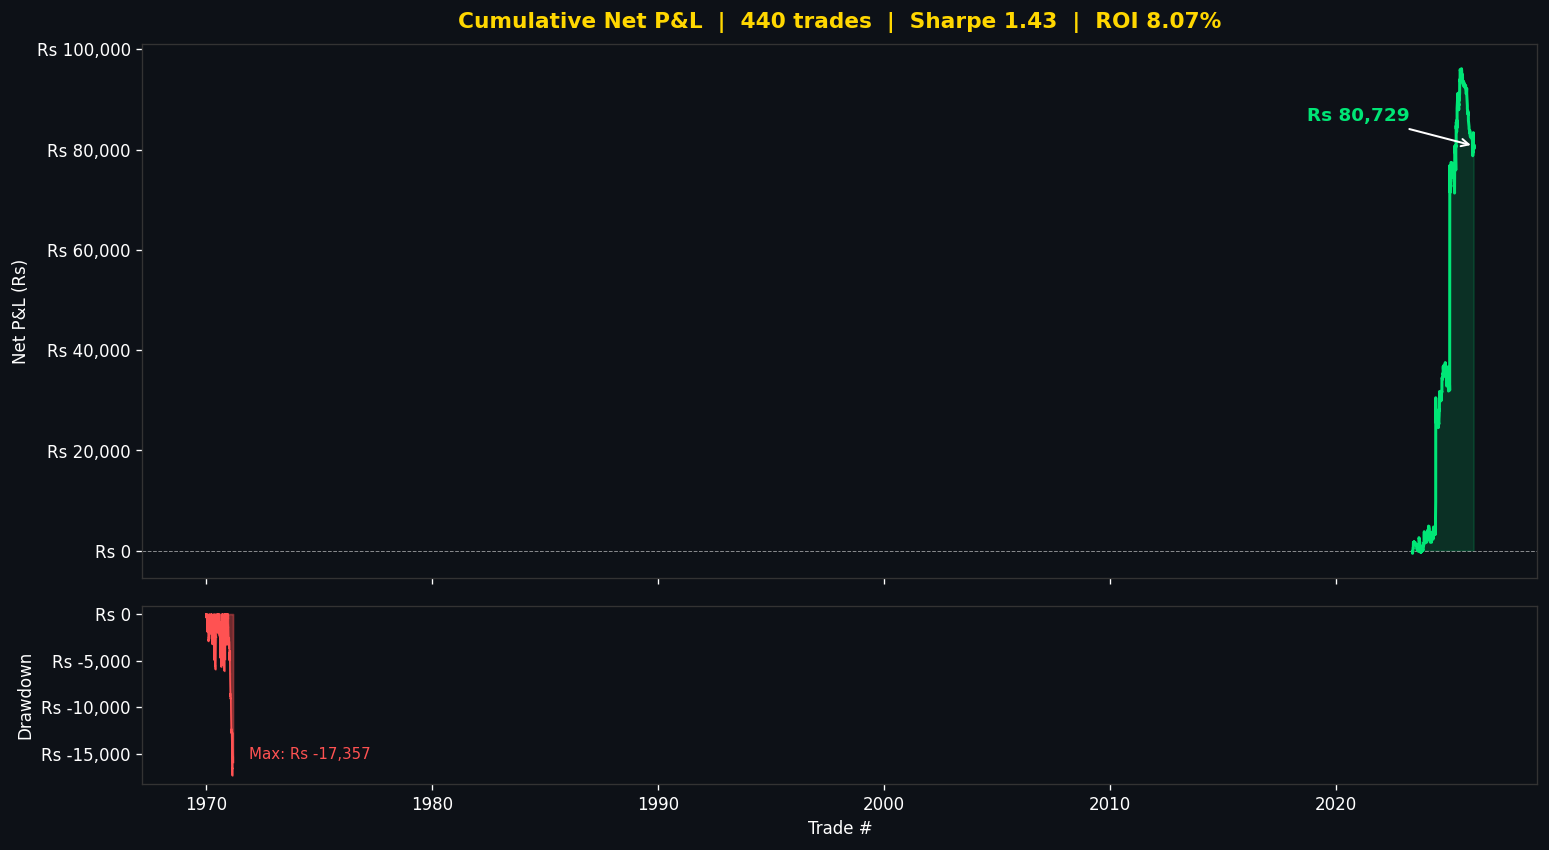

In [39]:
# ============================================================
# CELL 9 -- CHART: Cumulative P&L + Drawdown
# ============================================================

xd = pd.to_datetime(tdf['exit_datetime'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True,
                                gridspec_kw={'hspace': 0.08, 'height_ratios': [3, 1]})
fig.patch.set_facecolor(DARK)
for ax in [ax1, ax2]: ax.set_facecolor(DARK)

ax1.plot(xd, cum, color=GREEN, lw=1.8, zorder=3)
ax1.fill_between(xd, cum, where=cum >  0, alpha=0.15, color=GREEN, zorder=2)
ax1.fill_between(xd, cum, where=cum <= 0, alpha=0.15, color=RED,   zorder=2)
ax1.axhline(0, color='white', lw=0.6, ls='--', alpha=0.5)
ax1.set_title(f'Cumulative Net P&L  |  {n} trades  |  Sharpe {sharpe:.2f}  |  ROI {roi:.2f}%',
              color=GOLD, fontsize=13, fontweight='bold', pad=10)
ax1.set_ylabel('Net P&L (Rs)', color='white')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'Rs {v:,.0f}'))
ax1.tick_params(colors='white')
ax1.annotate(f'Rs {net:,.0f}', xy=(xd.iloc[-1], cum.iloc[-1]),
             xytext=(-100, 15 if net > 0 else -25), textcoords='offset points',
             color=GREEN if net > 0 else RED, fontsize=11, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='white', lw=1.2))
for spine in ax1.spines.values(): spine.set_edgecolor('#333')

ax2.fill_between(range(len(dd_ser)), dd_ser, 0, color=RED, alpha=0.4)
ax2.plot(dd_ser.values, color=RED, lw=1.0)
ax2.set_ylabel('Drawdown', color='white')
ax2.set_xlabel('Trade #', color='white')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'Rs {v:,.0f}'))
ax2.tick_params(colors='white')
ax2.annotate(f'Max: Rs {max_dd:,.0f}', xy=(dd_ser.idxmin(), max_dd),
             xytext=(10, 10), textcoords='offset points', color=RED, fontsize=9)
for spine in ax2.spines.values(): spine.set_edgecolor('#333')

plt.savefig(OUTPUT_DIR / 'chart_cumulative_pnl.png', dpi=130, bbox_inches='tight', facecolor=DARK)
plt.show()

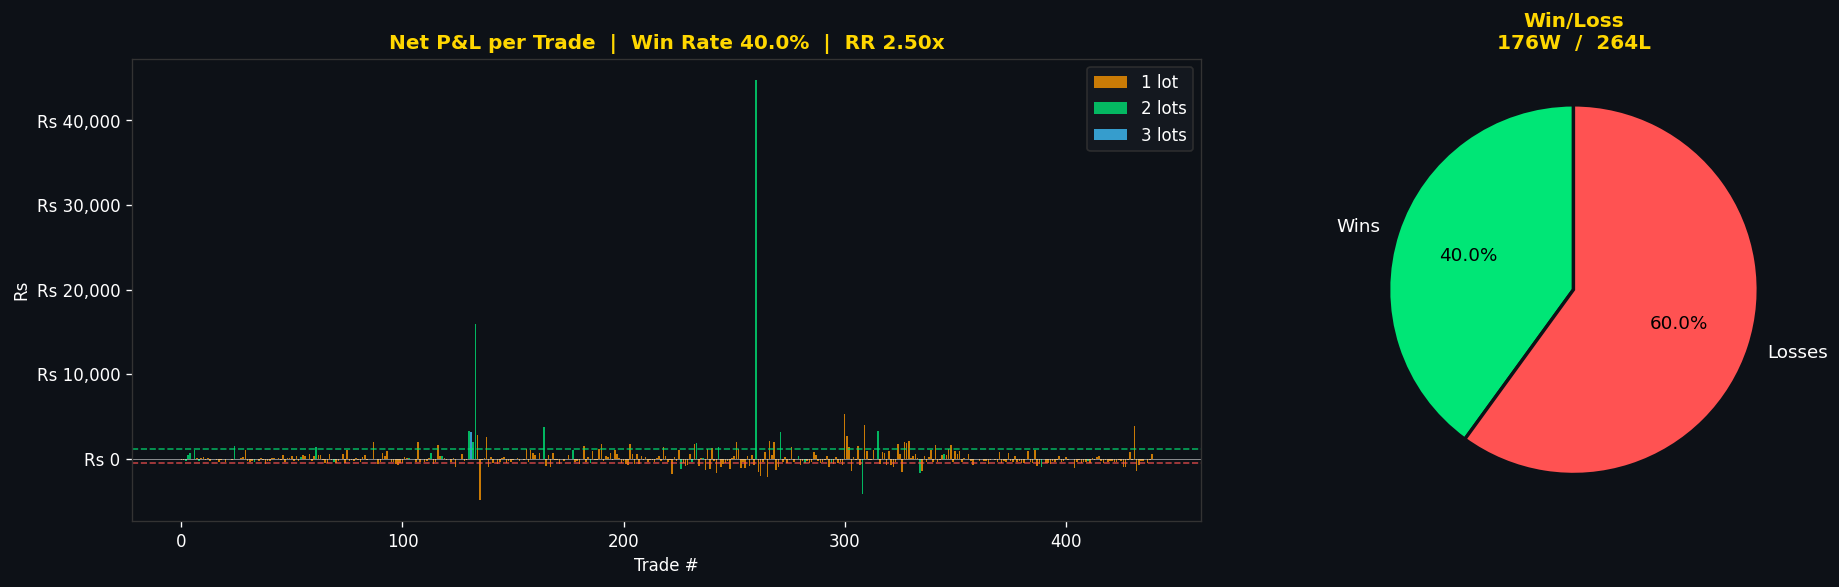

In [40]:
# ============================================================
# CELL 10 -- CHART: Per-Trade P&L + Win/Loss Pie
# ============================================================

fig = plt.figure(figsize=(18, 5))
fig.patch.set_facecolor(DARK)
gs  = fig.add_gridspec(1, 3, wspace=0.3)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2])

# Color by lot size
lot_colors = {1: ORANGE, 2: GREEN, 3: BLUE}
bc = [lot_colors.get(lot, PURPLE) for lot in tdf['lots']]

ax1.bar(range(n), tdf['net_pnl'], color=bc, alpha=0.78, width=0.7)
ax1.axhline(0,     color='white', lw=0.5, alpha=0.6)
ax1.axhline(avg_w, color=GREEN,   lw=1,   ls='--', alpha=0.7, label=f'Avg win Rs {avg_w:,.0f}')
ax1.axhline(avg_l, color=RED,     lw=1,   ls='--', alpha=0.7, label=f'Avg loss Rs {avg_l:,.0f}')
ax1.set_title(f'Net P&L per Trade  |  Win Rate {wr:.1f}%  |  RR {rr:.2f}x',
              color=GOLD, fontsize=12, fontweight='bold')
ax1.set_xlabel('Trade #', color='white')
ax1.set_ylabel('Rs', color='white')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'Rs {v:,.0f}'))
ax1.tick_params(colors='white')
ax1.legend(facecolor='#161b22', edgecolor='#333', labelcolor='white', fontsize=9)
ax1.set_facecolor(DARK)
for spine in ax1.spines.values(): spine.set_edgecolor('#333')

# Add legend for lot sizes
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=ORANGE, alpha=0.78, label='1 lot'),
                   Patch(facecolor=GREEN, alpha=0.78, label='2 lots'),
                   Patch(facecolor=BLUE, alpha=0.78, label='3 lots')]
ax1.legend(handles=legend_elements, loc='upper right', facecolor='#161b22', 
           edgecolor='#333', labelcolor='white')

ax2.set_facecolor(DARK)
wedges, texts, autotexts = ax2.pie(
    [wc, lc], labels=['Wins', 'Losses'], colors=[GREEN, RED],
    autopct='%1.1f%%', startangle=90,
    textprops={'color': 'white', 'fontsize': 11},
    wedgeprops={'edgecolor': DARK, 'linewidth': 2}
)
for at in autotexts: at.set_color('black'); at.set_fontsize(11)
ax2.set_title(f'Win/Loss\n{wc}W  /  {lc}L', color=GOLD, fontsize=12, fontweight='bold')

plt.savefig(OUTPUT_DIR / 'chart_pertrade_pnl.png', dpi=130, bbox_inches='tight', facecolor=DARK)
plt.show()

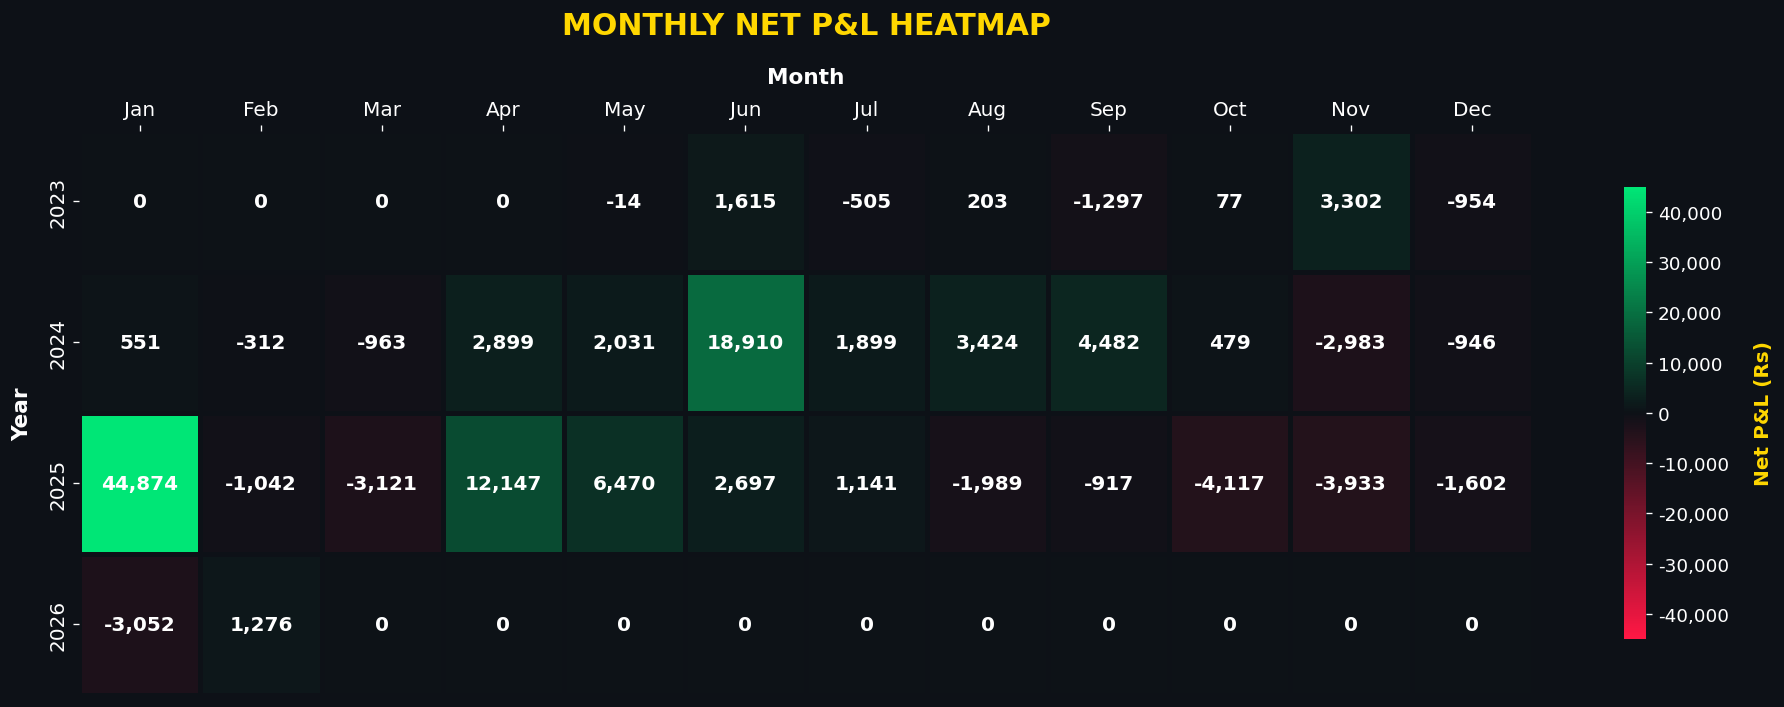

In [66]:
# ============================================================
# CELL 11 -- CHART: Monthly P&L Heatmap (Institutional Dark Mode)
# ============================================================
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

mp        = tdf.copy()
mp['yr']  = pd.to_datetime(mp['date']).dt.year
mp['mo']  = pd.to_datetime(mp['date']).dt.month
piv       = mp.groupby(['yr','mo'])['net_pnl'].sum().unstack(fill_value=0)
mlbls     = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Safely map only the months that exist in the data
piv.columns = [mlbls[c-1] for c in piv.columns]
piv.index   = [str(y) for y in piv.index]

fig, ax = plt.subplots(figsize=(16, max(4, len(piv) * 1.5)))
fig.patch.set_facecolor(DARK)
ax.set_facecolor(DARK)

# 1. The Quant Colormap (Crimson -> Dark Space -> Neon Green)
colors = ['#FF1744', DARK, '#00E676'] 
custom_cmap = LinearSegmentedColormap.from_list('quant_neon', colors, N=256)

# 2. Symmetrical Color Scaling (Forces 0 to be exactly in the dark center)
max_val = np.abs(piv.values).max()
vmin, vmax = -max_val, max_val

# 3. Plot Heatmap (fmt=',.0f' adds commas for easy reading!)
heatmap = sns.heatmap(piv, ax=ax, annot=True, fmt=',.0f',
                      cmap=custom_cmap, center=0,
                      vmin=vmin, vmax=vmax,
                      linewidths=2, linecolor=DARK, # Blends borders seamlessly
                      annot_kws={'size': 12, 'fontweight': 'bold', 'color': 'white'},
                      cbar_kws={'shrink': 0.8})

# 4. Colorbar Styling with Commas
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(colors='white', labelsize=11)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
cbar.set_label('Net P&L (Rs)', color=GOLD, fontsize=12, fontweight='bold', labelpad=15)

# 5. Clean Institutional Titles & Labels
ax.set_title('MONTHLY NET P&L HEATMAP', color=GOLD, fontsize=18, fontweight='heavy', pad=20)
ax.set_ylabel('Year', color='white', fontsize=13, fontweight='bold', labelpad=10)
ax.set_xlabel('Month', color='white', fontsize=13, fontweight='bold', labelpad=10)
ax.tick_params(colors='white', labelsize=12)

# Move X-axis ticks to the top for a cleaner look
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.tight_layout()

# SAVE TO YOUR NEW TIMESTAMPED FOLDER!
plt.savefig(OUTPUT_DIR / 'chart_monthly_heatmap_pro.png', dpi=200, 
            bbox_inches='tight', facecolor=DARK)
plt.show()

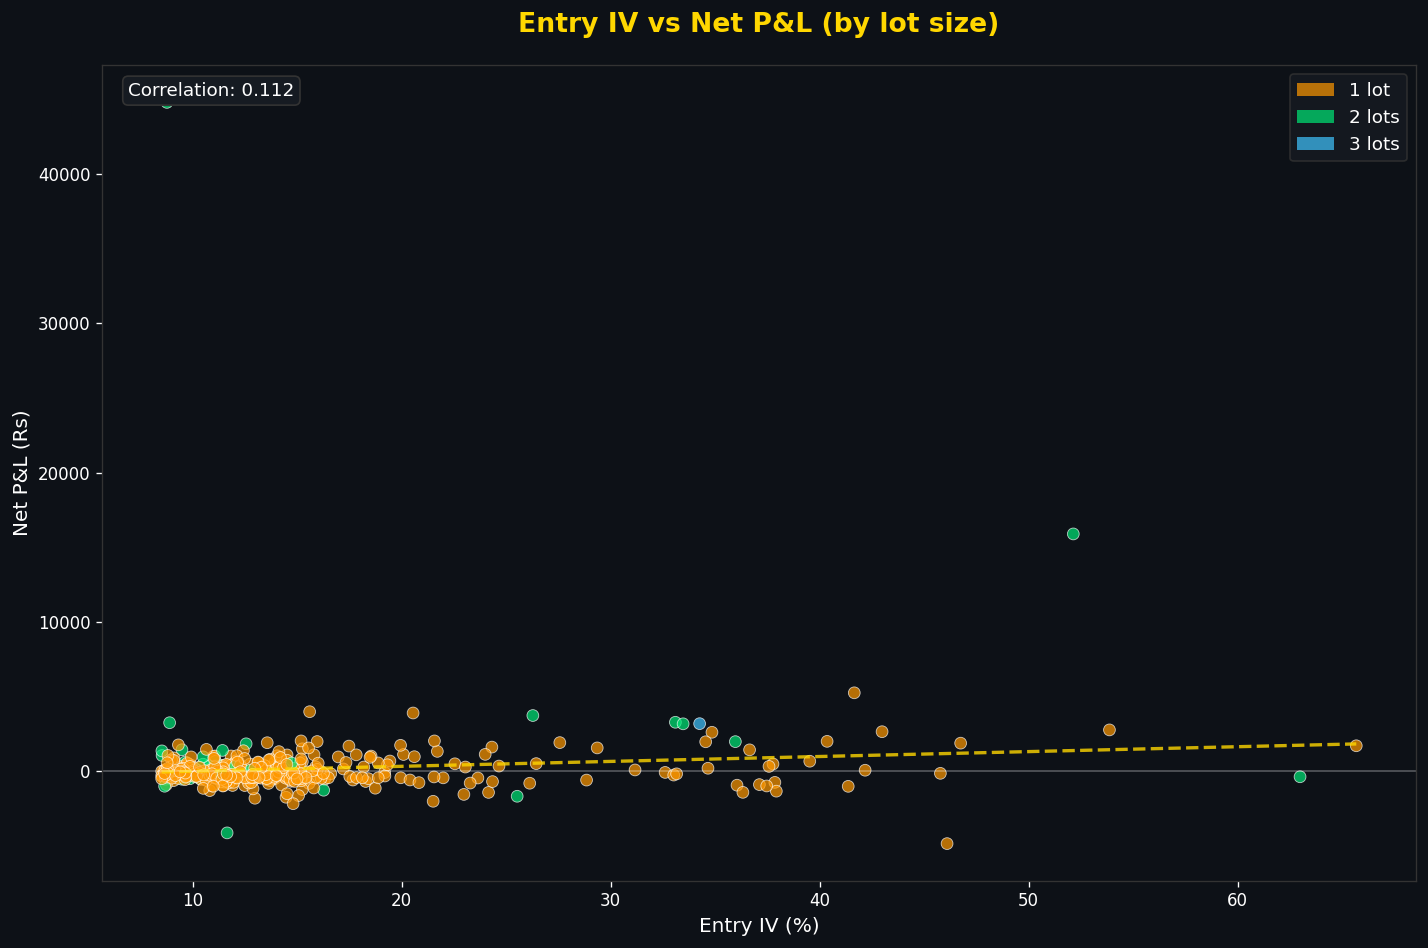

In [43]:
# ============================================================
# CELL 12a -- CHART: Entry IV vs Net P&L
# ============================================================

fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor(DARK)
ax.set_facecolor(DARK)

lot_colors_map = {1: ORANGE, 2: GREEN, 3: BLUE}
sc = ax.scatter(tdf['entry_iv'], tdf['net_pnl'], 
                c=tdf['lots'].map(lot_colors_map), alpha=0.7, s=50, edgecolors='white', linewidth=0.5)

# Add trend line
z = np.polyfit(tdf['entry_iv'], tdf['net_pnl'], 1)
p = np.poly1d(z)
ax.plot(tdf['entry_iv'].sort_values(), p(tdf['entry_iv'].sort_values()), 
        color=GOLD, lw=2, ls='--', alpha=0.8, label=f'Trend: slope={z[0]:.2f}')

ax.axhline(0, color='white', lw=1, ls='-', alpha=0.3)
ax.set_title('Entry IV vs Net P&L (by lot size)', color=GOLD, fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Entry IV (%)', color='white', fontsize=12)
ax.set_ylabel('Net P&L (Rs)', color='white', fontsize=12)
ax.tick_params(colors='white', labelsize=10)

# Add legend for lot sizes
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=ORANGE, alpha=0.7, label='1 lot'),
                   Patch(facecolor=GREEN, alpha=0.7, label='2 lots'),
                   Patch(facecolor=BLUE, alpha=0.7, label='3 lots')]
ax.legend(handles=legend_elements, loc='upper right', facecolor='#161b22', 
          edgecolor='#333', labelcolor='white', fontsize=11)

# Add stats box
stats_text = f'Correlation: {tdf["entry_iv"].corr(tdf["net_pnl"]):.3f}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, color='white', 
        fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='#161b22', edgecolor='#333'))

for spine in ax.spines.values(): spine.set_edgecolor('#333')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'chart_entry_iv_vs_pnl.png', dpi=150, bbox_inches='tight', facecolor=DARK)
plt.show()

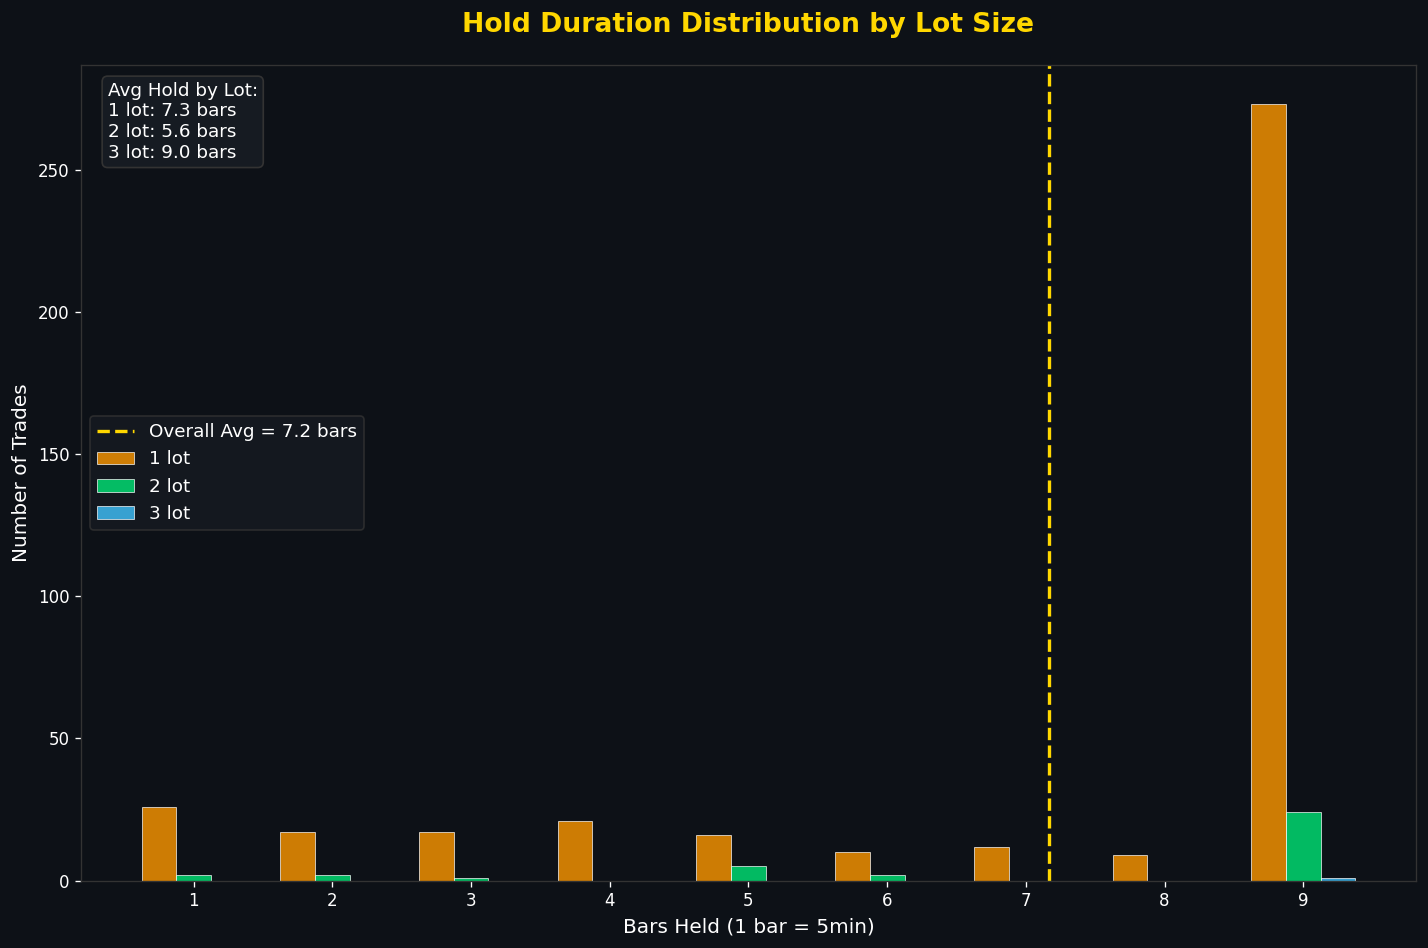

In [44]:
# ============================================================
# CELL 12b -- CHART: Hold Duration by Lot Size
# ============================================================

fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor(DARK)
ax.set_facecolor(DARK)

lot_colors_map = {1: ORANGE, 2: GREEN, 3: BLUE}
bar_width = 0.25
x_pos = np.arange(1, MAX_HOLD_BARS + 1)

for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    counts = [subset[subset['bars_held'] == i].shape[0] for i in range(1, MAX_HOLD_BARS + 1)]
    ax.bar(x_pos + (lots-2)*bar_width, counts, bar_width, 
           label=f'{lots} lot', color=lot_colors_map[lots], alpha=0.8, edgecolor='white', linewidth=0.5)

ax.axvline(tdf['bars_held'].mean(), color=GOLD, lw=2, ls='--',
           label=f'Overall Avg = {tdf["bars_held"].mean():.1f} bars')

ax.set_title('Hold Duration Distribution by Lot Size', color=GOLD, fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel(f'Bars Held (1 bar = {USE_TIMEFRAME})', color='white', fontsize=12)
ax.set_ylabel('Number of Trades', color='white', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels([str(i) for i in range(1, MAX_HOLD_BARS + 1)])
ax.tick_params(colors='white', labelsize=10)
ax.legend(facecolor='#161b22', edgecolor='#333', labelcolor='white', fontsize=11)

# Add stats box
avg_by_lot = tdf.groupby('lots')['bars_held'].mean().round(1)
stats_text = "Avg Hold by Lot:\n" + "\n".join([f"{lots} lot: {avg:.1f} bars" for lots, avg in avg_by_lot.items()])
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, color='white', 
        fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='#161b22', edgecolor='#333'))

for spine in ax.spines.values(): spine.set_edgecolor('#333')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'chart_hold_duration.png', dpi=150, bbox_inches='tight', facecolor=DARK)
plt.show()

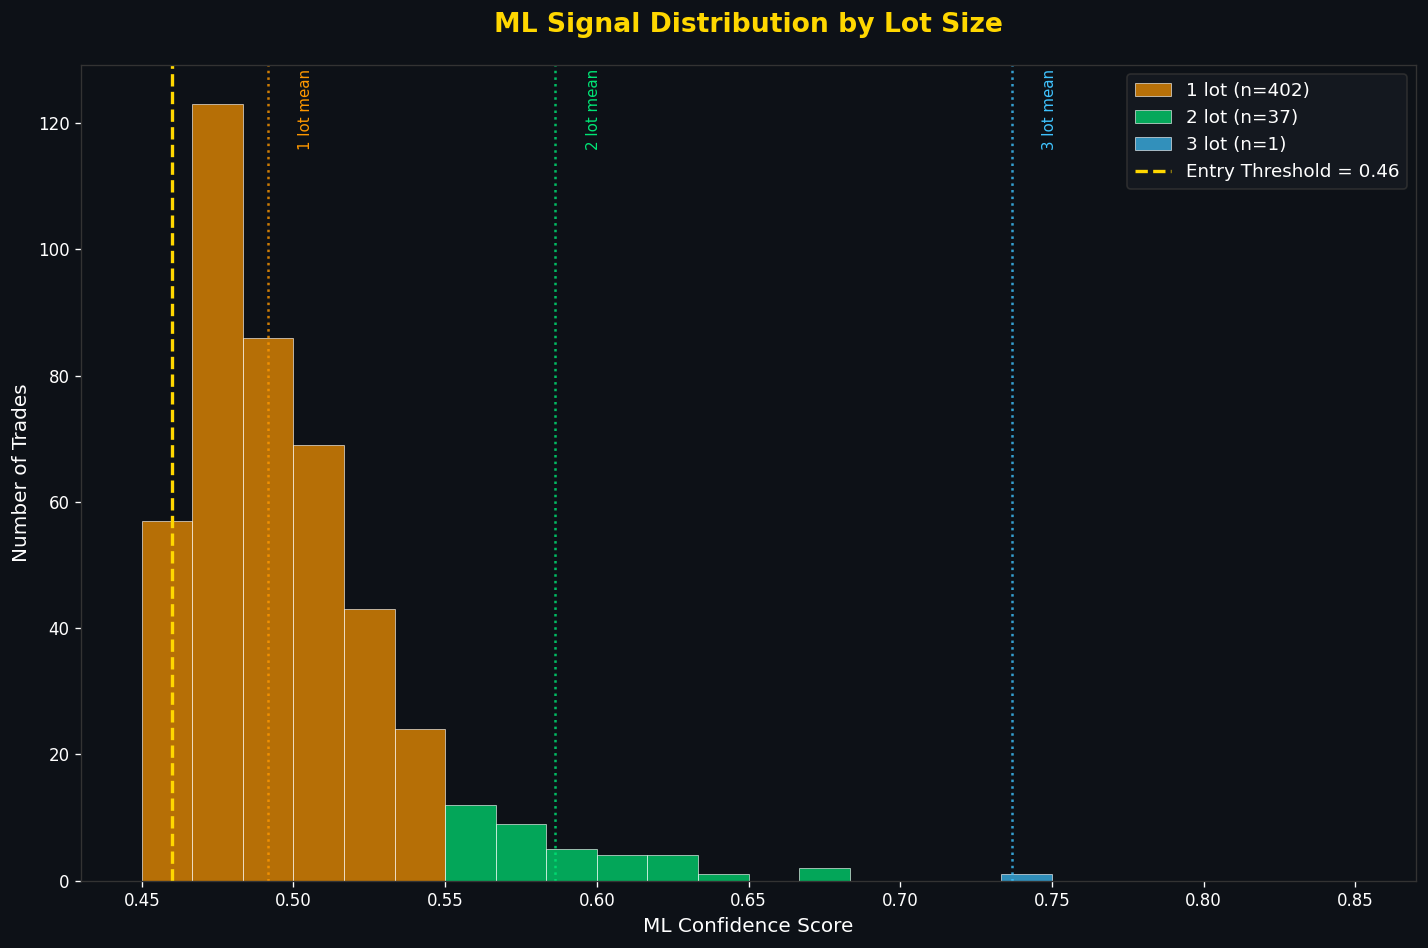

In [45]:
# ============================================================
# CELL 12c -- CHART: ML Signal Distribution by Lot Size
# ============================================================

fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor(DARK)
ax.set_facecolor(DARK)

lot_colors_map = {1: ORANGE, 2: GREEN, 3: BLUE}
bins = np.linspace(0.45, 0.85, 25)

for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    ax.hist(subset['ml_signal'], bins=bins, alpha=0.7, 
            label=f'{lots} lot (n={len(subset)})', color=lot_colors_map[lots],
            edgecolor='white', linewidth=0.5)

ax.axvline(ML_THRESHOLD, color=GOLD, lw=2, ls='--', 
           label=f'Entry Threshold = {ML_THRESHOLD:.2f}')

ax.set_title('ML Signal Distribution by Lot Size', color=GOLD, fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('ML Confidence Score', color='white', fontsize=12)
ax.set_ylabel('Number of Trades', color='white', fontsize=12)
ax.tick_params(colors='white', labelsize=10)
ax.legend(facecolor='#161b22', edgecolor='#333', labelcolor='white', fontsize=11)

# Add mean lines for each lot size
for lots in [1, 2, 3]:
    mean_val = tdf[tdf['lots'] == lots]['ml_signal'].mean()
    ax.axvline(mean_val, color=lot_colors_map[lots], lw=1.5, ls=':', alpha=0.8)
    ax.text(mean_val+0.01, ax.get_ylim()[1]*0.9, f'{lots} lot mean', 
            color=lot_colors_map[lots], fontsize=9, rotation=90)

for spine in ax.spines.values(): spine.set_edgecolor('#333')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'chart_ml_signal_dist.png', dpi=150, bbox_inches='tight', facecolor=DARK)
plt.show()

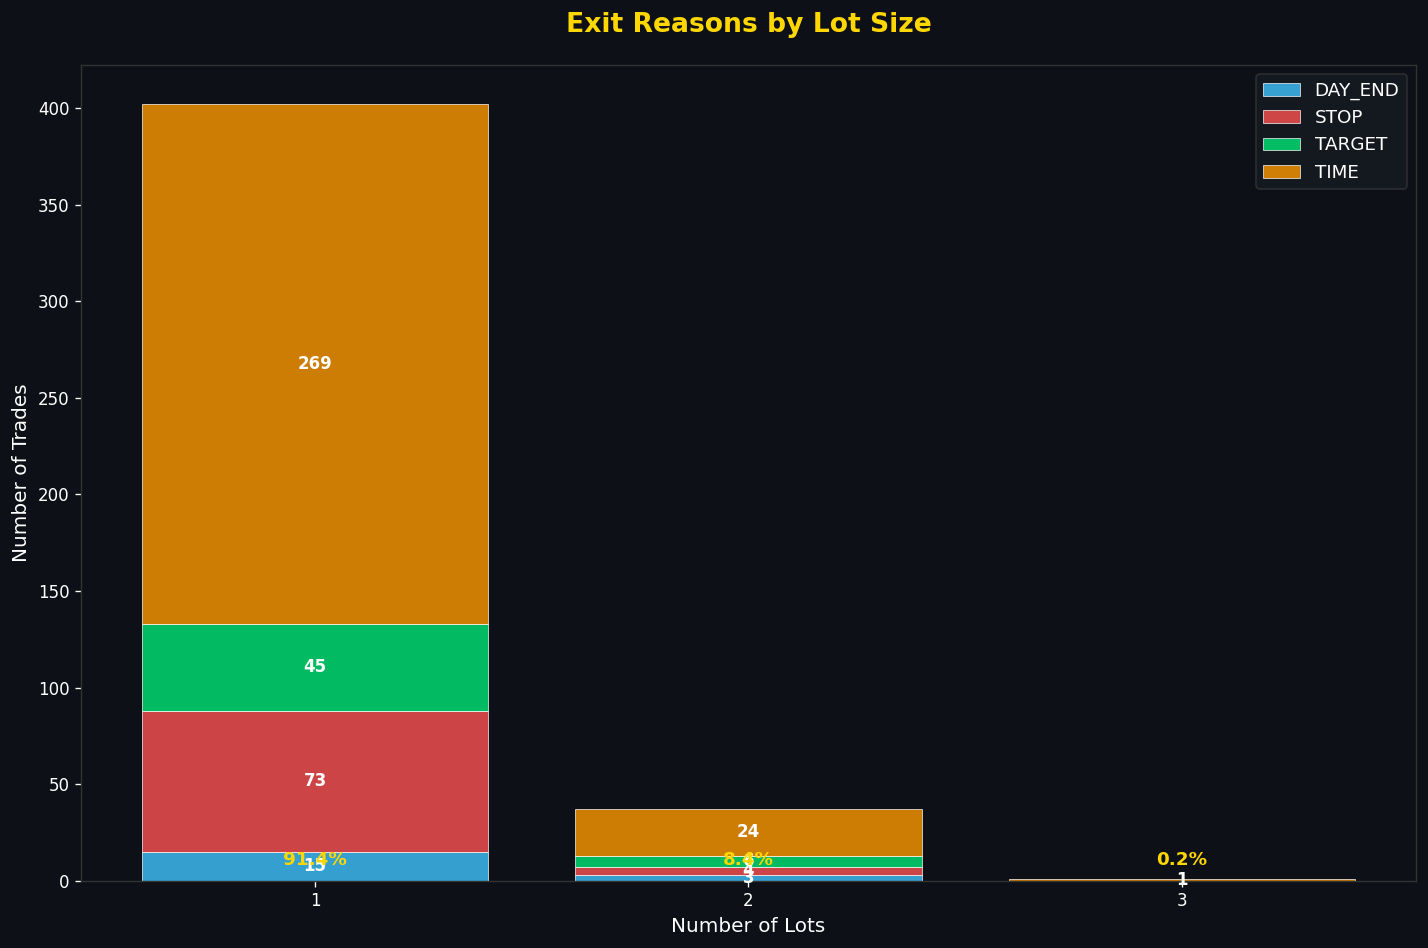

In [46]:
# ============================================================
# CELL 12d -- CHART: Exit Reasons by Lot Size
# ============================================================

fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor(DARK)
ax.set_facecolor(DARK)

exit_by_lot = tdf.groupby(['lots', 'exit_reason']).size().unstack(fill_value=0)

# Define colors for exit reasons
exit_colors = {
    'TARGET': GREEN,
    'STOP': RED,
    'TIME': ORANGE,
    'DAY_END': BLUE,
    'TRAIL_STOP': PURPLE
}

# Plot stacked bars
bottom = np.zeros(len(exit_by_lot.index))
for reason in exit_by_lot.columns:
    values = exit_by_lot[reason].values
    ax.bar(exit_by_lot.index, values, bottom=bottom, 
           label=reason, color=exit_colors.get(reason, '#888888'),
           alpha=0.8, edgecolor='white', linewidth=0.5)
    bottom += values

# Add value labels on bars
for i, lots in enumerate(exit_by_lot.index):
    cumulative = 0
    for reason in exit_by_lot.columns:
        value = exit_by_lot.loc[lots, reason]
        if value > 0:
            ax.text(lots, cumulative + value/2, str(value), 
                   ha='center', va='center', color='white', fontweight='bold', fontsize=10)
        cumulative += value

ax.set_title('Exit Reasons by Lot Size', color=GOLD, fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Number of Lots', color='white', fontsize=12)
ax.set_ylabel('Number of Trades', color='white', fontsize=12)
ax.set_xticks([1, 2, 3])
ax.tick_params(colors='white', labelsize=10)
ax.legend(facecolor='#161b22', edgecolor='#333', labelcolor='white', fontsize=11)

# Add percentages
total_trades = len(tdf)
for lots in [1, 2, 3]:
    lot_total = exit_by_lot.loc[lots].sum()
    pct = (lot_total / total_trades) * 100
    ax.text(lots, bottom[i] + 5, f'{pct:.1f}%', 
            ha='center', va='bottom', color=GOLD, fontweight='bold', fontsize=11)

for spine in ax.spines.values(): spine.set_edgecolor('#333')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'chart_exit_reasons.png', dpi=150, bbox_inches='tight', facecolor=DARK)
plt.show()

In [47]:
# ============================================================
# CELL 12e -- SUMMARY STATS for Analytics (Optional)
# ============================================================

print("\n" + "="*60)
print("ANALYTICS SUMMARY STATISTICS")
print("="*60)

print("\n--- Entry IV Analysis ---")
print(f"  Avg Entry IV (Winners): {tdf[tdf['net_pnl']>0]['entry_iv'].mean():.2f}%")
print(f"  Avg Entry IV (Losers):  {tdf[tdf['net_pnl']<=0]['entry_iv'].mean():.2f}%")
print(f"  Correlation IV vs P&L:  {tdf['entry_iv'].corr(tdf['net_pnl']):.3f}")

print("\n--- Hold Duration Analysis ---")
print(f"  Avg Hold (Winners): {tdf[tdf['net_pnl']>0]['bars_held'].mean():.1f} bars")
print(f"  Avg Hold (Losers):  {tdf[tdf['net_pnl']<=0]['bars_held'].mean():.1f} bars")
print("\n  Avg Hold by Lot Size:")
for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    print(f"    {lots} lot: {subset['bars_held'].mean():.1f} bars ({len(subset)} trades)")

print("\n--- ML Signal Analysis ---")
print(f"  Avg ML Signal (Winners): {tdf[tdf['net_pnl']>0]['ml_signal'].mean():.4f}")
print(f"  Avg ML Signal (Losers):  {tdf[tdf['net_pnl']<=0]['ml_signal'].mean():.4f}")
print("\n  ML Signal by Lot Size:")
for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    print(f"    {lots} lot: {subset['ml_signal'].mean():.4f} (min={subset['ml_signal'].min():.4f}, max={subset['ml_signal'].max():.4f})")

print("\n--- Exit Reason Analysis ---")
exit_pct = tdf['exit_reason'].value_counts(normalize=True) * 100
for reason, pct in exit_pct.items():
    print(f"  {reason}: {pct:.1f}% ({tdf[tdf['exit_reason']==reason].shape[0]} trades)")

print("="*60)


ANALYTICS SUMMARY STATISTICS

--- Entry IV Analysis ---
  Avg Entry IV (Winners): 16.55%
  Avg Entry IV (Losers):  14.21%
  Correlation IV vs P&L:  0.112

--- Hold Duration Analysis ---
  Avg Hold (Winners): 6.8 bars
  Avg Hold (Losers):  7.4 bars

  Avg Hold by Lot Size:
    1 lot: 7.3 bars (402 trades)
    2 lot: 5.6 bars (37 trades)
    3 lot: 9.0 bars (1 trades)

--- ML Signal Analysis ---
  Avg ML Signal (Winners): 0.5075
  Avg ML Signal (Losers):  0.4950

  ML Signal by Lot Size:
    1 lot: 0.4915 (min=0.4501, max=0.5492)
    2 lot: 0.5863 (min=0.5511, max=0.6817)
    3 lot: 0.7368 (min=0.7368, max=0.7368)

--- Exit Reason Analysis ---
  TIME: 66.8% (294 trades)
  STOP: 17.5% (77 trades)
  TARGET: 11.6% (51 trades)
  DAY_END: 4.1% (18 trades)


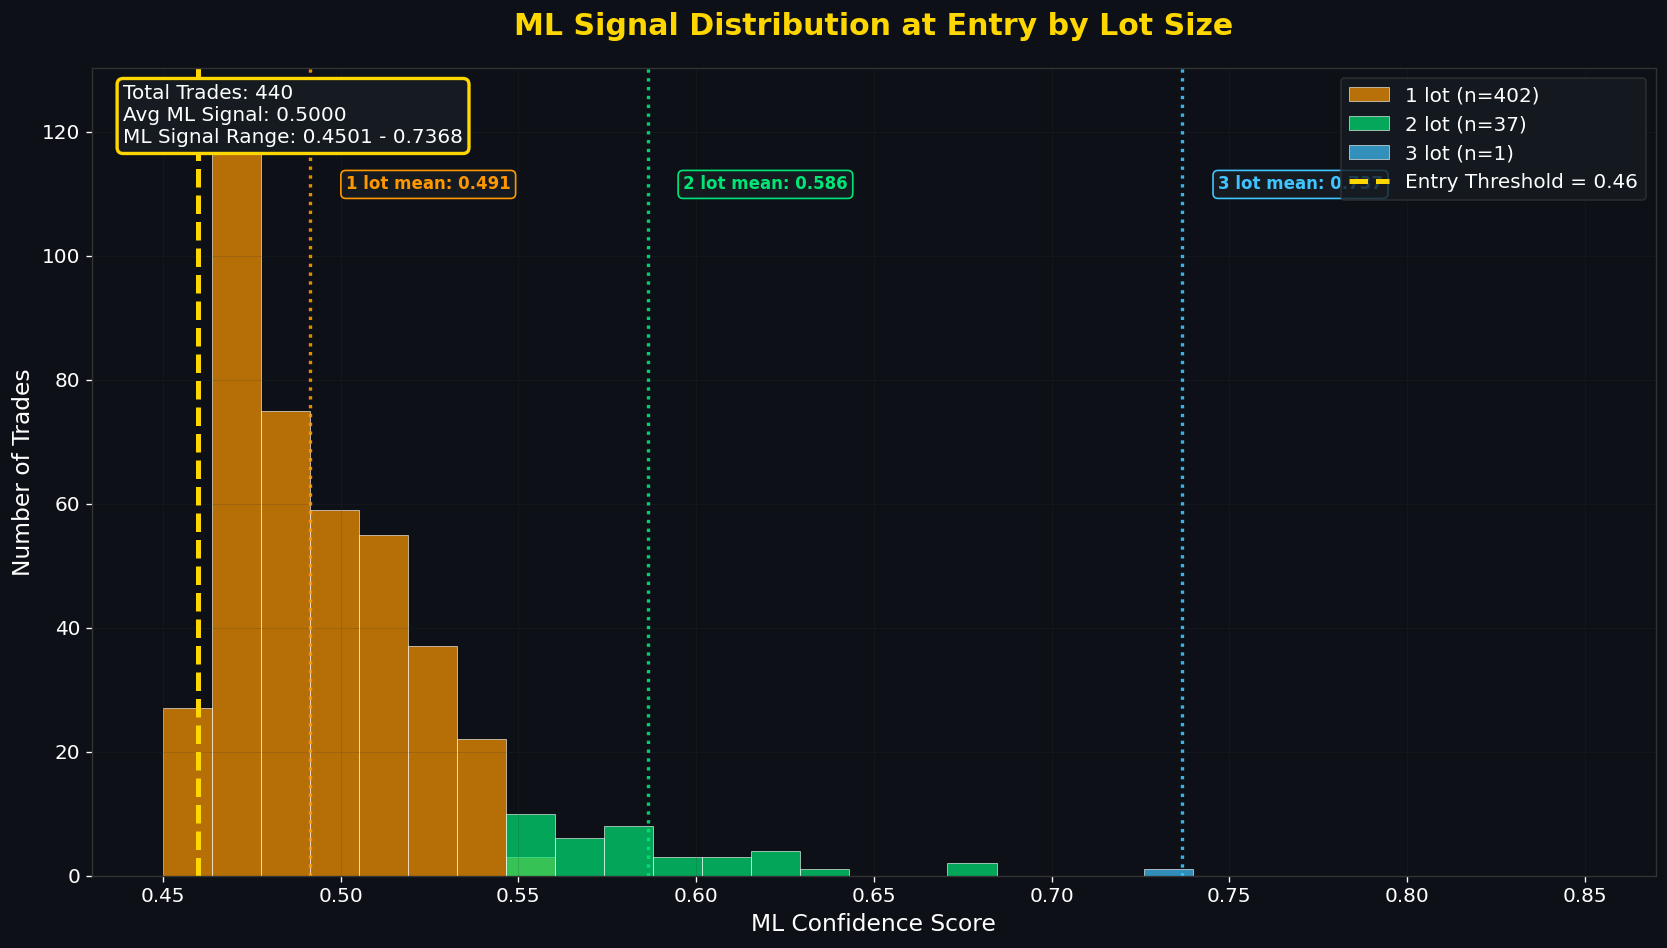

In [49]:
# ============================================================
# CELL 13a -- CHART: ML Signal Distribution by Lot Size
# ============================================================

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor(DARK)
ax.set_facecolor(DARK)

lot_colors_map = {1: ORANGE, 2: GREEN, 3: BLUE}
bins = np.linspace(0.45, 0.85, 30)

for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    ax.hist(subset['ml_signal'], bins=bins, alpha=0.7, 
            label=f'{lots} lot (n={len(subset)})', color=lot_colors_map[lots],
            edgecolor='white', linewidth=0.5)

ax.axvline(ML_THRESHOLD, color=GOLD, lw=3, ls='--', 
           label=f'Entry Threshold = {ML_THRESHOLD:.2f}')

# Add vertical lines for means
for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    mean_val = subset['ml_signal'].mean()
    ax.axvline(mean_val, color=lot_colors_map[lots], lw=2, ls=':', alpha=0.9)
    ax.text(mean_val+0.01, ax.get_ylim()[1]*0.85, f'{lots} lot mean: {mean_val:.3f}', 
            color=lot_colors_map[lots], fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#161b22', edgecolor=lot_colors_map[lots]))

ax.set_title('ML Signal Distribution at Entry by Lot Size', color=GOLD, fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('ML Confidence Score', color='white', fontsize=14)
ax.set_ylabel('Number of Trades', color='white', fontsize=14)
ax.tick_params(colors='white', labelsize=12)
ax.legend(facecolor='#161b22', edgecolor='#333', labelcolor='white', fontsize=12, loc='upper right')

# Add grid for better readability
ax.grid(True, alpha=0.2, color='#333333', linestyle='-', linewidth=0.5)

# Stats box
stats_text = f"Total Trades: {len(tdf)}\n"
stats_text += f"Avg ML Signal: {tdf['ml_signal'].mean():.4f}\n"
stats_text += f"ML Signal Range: {tdf['ml_signal'].min():.4f} - {tdf['ml_signal'].max():.4f}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, color='white', 
        fontsize=12, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='#161b22', edgecolor=GOLD, linewidth=2))

for spine in ax.spines.values(): spine.set_edgecolor('#333')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'chart_ml_signal_distribution.png', dpi=150, bbox_inches='tight', facecolor=DARK)
plt.show()

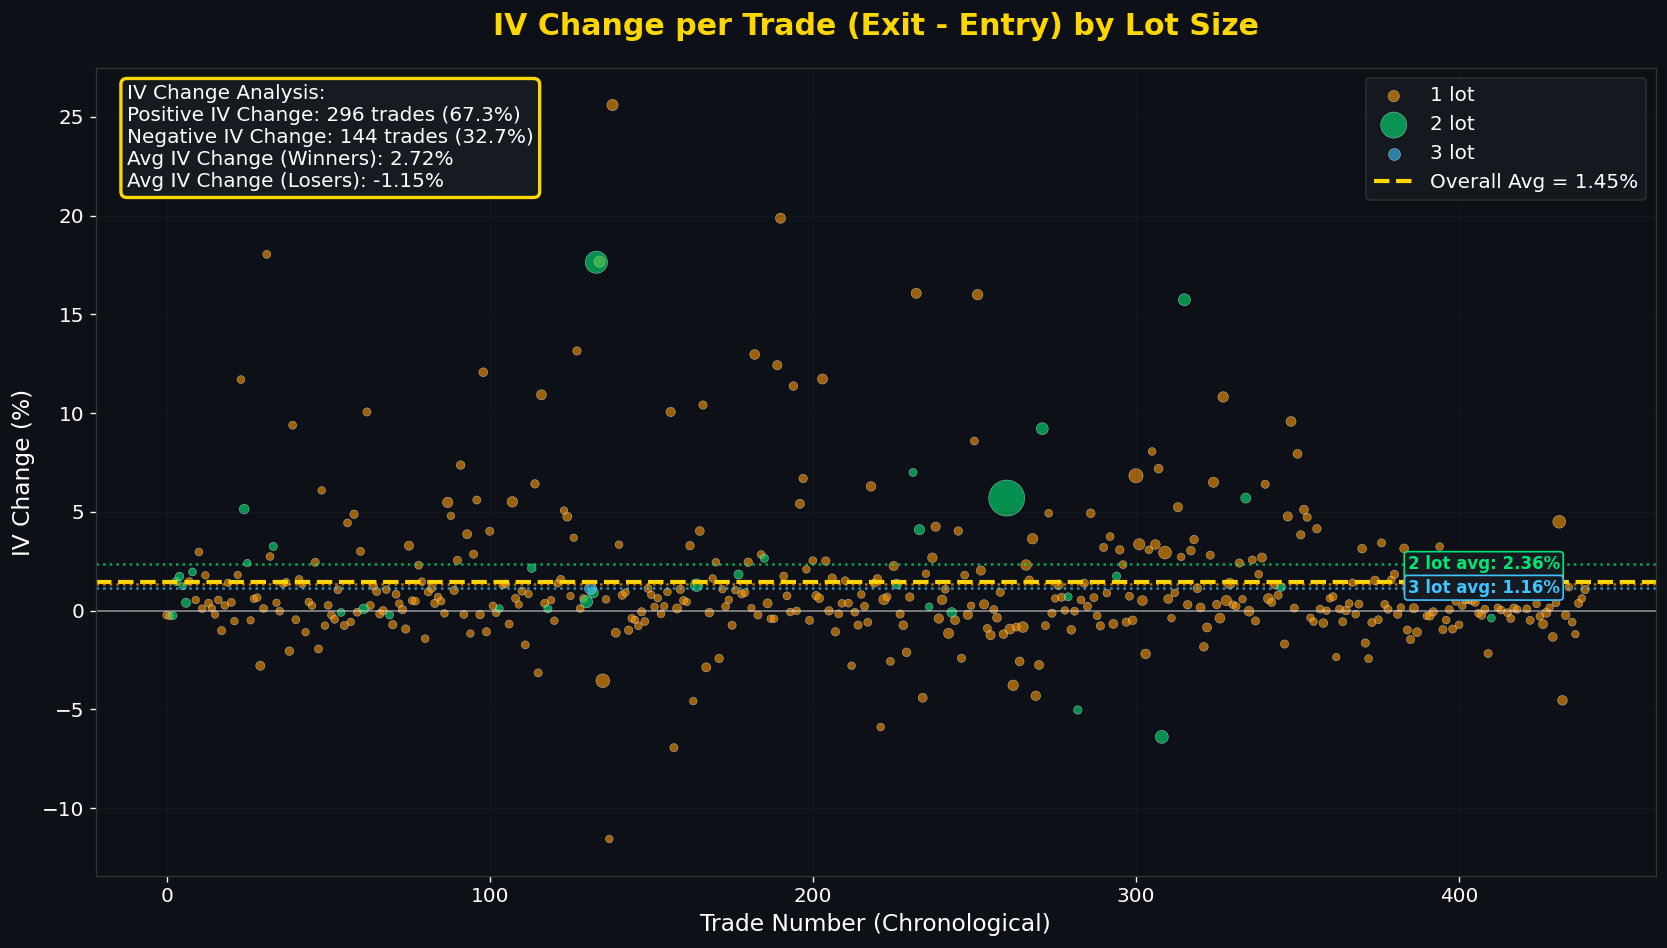

In [50]:
# ============================================================
# CELL 13b -- CHART: IV Change per Trade by Lot Size
# ============================================================

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor(DARK)
ax.set_facecolor(DARK)

lot_colors_map = {1: ORANGE, 2: GREEN, 3: BLUE}

# Create scatter plot with size based on |pnl|
for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    sizes = subset['net_pnl'].abs() / 100 + 20  # Size based on profit magnitude
    scatter = ax.scatter(subset.index, subset['iv_change'], 
                         c=[lot_colors_map[lots]] * len(subset), 
                         alpha=0.6, s=sizes, label=f'{lots} lot',
                         edgecolor='white', linewidth=0.3)

ax.axhline(0, color='white', lw=1, ls='-', alpha=0.5)
ax.axhline(tdf['iv_change'].mean(), color=GOLD, lw=2.5, ls='--',
           label=f'Overall Avg = {tdf["iv_change"].mean():.2f}%')

# Add horizontal lines for each lot size average
for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    avg_iv = subset['iv_change'].mean()
    ax.axhline(avg_iv, color=lot_colors_map[lots], lw=1.5, ls=':', alpha=0.7)
    ax.text(len(tdf)*0.98, avg_iv, f'{lots} lot avg: {avg_iv:.2f}%', 
            color=lot_colors_map[lots], fontsize=10, fontweight='bold',
            ha='right', va='center', bbox=dict(boxstyle='round,pad=0.2', facecolor='#161b22', edgecolor=lot_colors_map[lots]))

ax.set_title('IV Change per Trade (Exit - Entry) by Lot Size', color=GOLD, fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Trade Number (Chronological)', color='white', fontsize=14)
ax.set_ylabel('IV Change (%)', color='white', fontsize=14)
ax.tick_params(colors='white', labelsize=12)
ax.legend(facecolor='#161b22', edgecolor='#333', labelcolor='white', fontsize=12, loc='upper right')

# Add grid
ax.grid(True, alpha=0.2, color='#333333', linestyle='-', linewidth=0.5)

# Stats box
winners = tdf[tdf['iv_change'] > 0]
losers = tdf[tdf['iv_change'] <= 0]
stats_text = f"IV Change Analysis:\n"
stats_text += f"Positive IV Change: {len(winners)} trades ({len(winners)/len(tdf)*100:.1f}%)\n"
stats_text += f"Negative IV Change: {len(losers)} trades ({len(losers)/len(tdf)*100:.1f}%)\n"
stats_text += f"Avg IV Change (Winners): {winners['iv_change'].mean():.2f}%\n"
stats_text += f"Avg IV Change (Losers): {losers['iv_change'].mean():.2f}%"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, color='white', 
        fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='#161b22', edgecolor=GOLD, linewidth=2))

for spine in ax.spines.values(): spine.set_edgecolor('#333')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'chart_iv_change.png', dpi=150, bbox_inches='tight', facecolor=DARK)
plt.show()

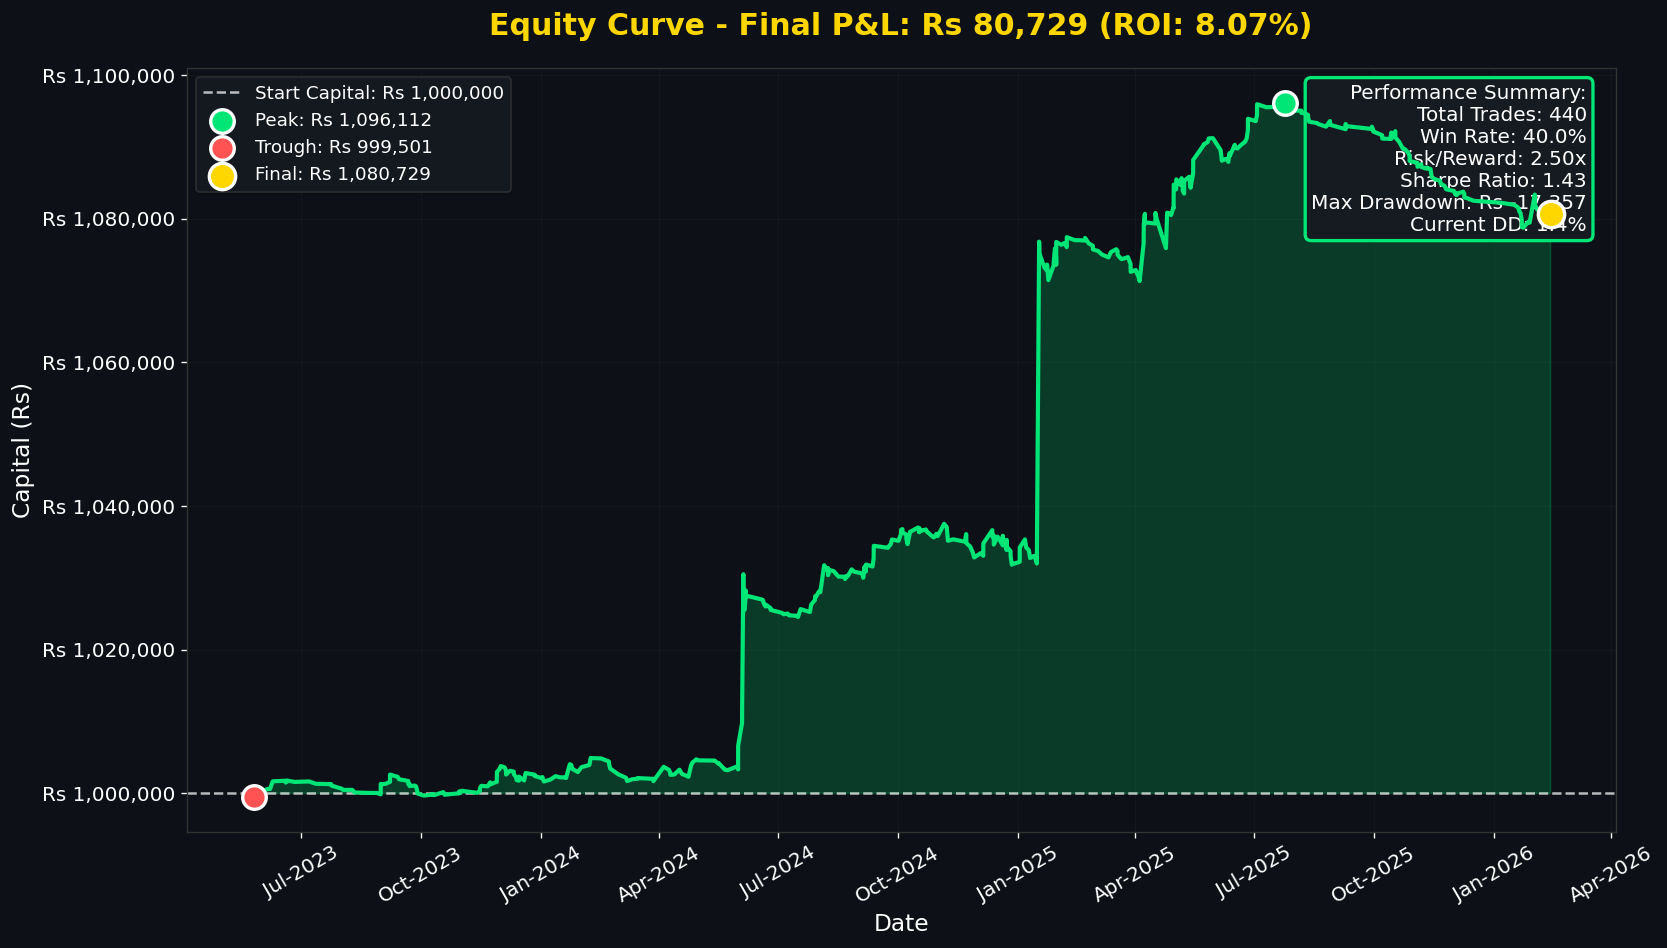

In [51]:
# ============================================================
# CELL 13c -- CHART: Equity Curve with Annotations
# ============================================================

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor(DARK)
ax.set_facecolor(DARK)

eq_df = pd.DataFrame(equity_curve, columns=['datetime','capital']).dropna()
eq_df['datetime'] = pd.to_datetime(eq_df['datetime'])

# Plot equity curve
ax.plot(eq_df['datetime'], eq_df['capital'], color=GREEN, lw=2.5, zorder=5)

# Fill between
ax.fill_between(eq_df['datetime'], eq_df['capital'], INITIAL_CAPITAL,
                where=eq_df['capital'] >= INITIAL_CAPITAL, alpha=0.2, color=GREEN, zorder=2)
ax.fill_between(eq_df['datetime'], eq_df['capital'], INITIAL_CAPITAL,
                where=eq_df['capital'] < INITIAL_CAPITAL, alpha=0.2, color=RED, zorder=2)

# Add horizontal line for starting capital
ax.axhline(INITIAL_CAPITAL, color='white', lw=1.5, ls='--', alpha=0.7,
           label=f'Start Capital: Rs {INITIAL_CAPITAL:,}')

# Mark major events
max_idx = eq_df['capital'].idxmax()
min_idx = eq_df['capital'].idxmin()

ax.scatter(eq_df.loc[max_idx, 'datetime'], eq_df.loc[max_idx, 'capital'], 
           color=GREEN, s=200, zorder=10, edgecolor='white', linewidth=2, label=f'Peak: Rs {eq_df.loc[max_idx, "capital"]:,.0f}')
ax.scatter(eq_df.loc[min_idx, 'datetime'], eq_df.loc[min_idx, 'capital'], 
           color=RED, s=200, zorder=10, edgecolor='white', linewidth=2, label=f'Trough: Rs {eq_df.loc[min_idx, "capital"]:,.0f}')

# Add final point marker
ax.scatter(eq_df.iloc[-1]['datetime'], eq_df.iloc[-1]['capital'], 
           color=GOLD, s=250, zorder=10, edgecolor='white', linewidth=2, 
           label=f'Final: Rs {eq_df.iloc[-1]["capital"]:,.0f}')

# Calculate drawdown for annotation
current_dd = (eq_df['capital'].max() - eq_df['capital'].iloc[-1]) / eq_df['capital'].max() * 100

ax.set_title(f'Equity Curve - Final P&L: Rs {net:,.0f} (ROI: {roi:.2f}%)', 
             color=GOLD, fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Date', color='white', fontsize=14)
ax.set_ylabel('Capital (Rs)', color='white', fontsize=14)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'Rs {v:,.0f}'))
ax.tick_params(colors='white', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
ax.legend(facecolor='#161b22', edgecolor='#333', labelcolor='white', fontsize=11, loc='upper left')

# Add grid
ax.grid(True, alpha=0.2, color='#333333', linestyle='-', linewidth=0.5)

# Stats box
stats_text = f"Performance Summary:\n"
stats_text += f"Total Trades: {len(tdf)}\n"
stats_text += f"Win Rate: {wr:.1f}%\n"
stats_text += f"Risk/Reward: {rr:.2f}x\n"
stats_text += f"Sharpe Ratio: {sharpe:.2f}\n"
stats_text += f"Max Drawdown: Rs {max_dd:,.0f}\n"
stats_text += f"Current DD: {current_dd:.1f}%"
ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, color='white', 
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='#161b22', edgecolor=GREEN, linewidth=2))

for spine in ax.spines.values(): spine.set_edgecolor('#333')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'chart_equity_curve.png', dpi=150, bbox_inches='tight', facecolor=DARK)
plt.show()

In [52]:
# ============================================================
# CELL 13d -- SUMMARY STATS for ML/IV Analysis (Optional)
# ============================================================

print("\n" + "="*70)
print("ML SIGNAL & IV CHANGE ANALYSIS SUMMARY")
print("="*70)

print("\n--- ML SIGNAL STATISTICS ---")
print(f"  Overall ML Signal Avg: {tdf['ml_signal'].mean():.4f}")
print(f"  ML Signal Std Dev:     {tdf['ml_signal'].std():.4f}")

print("\n  ML Signal by Lot Size:")
for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    print(f"    {lots} lot ({len(subset)} trades):")
    print(f"      Avg: {subset['ml_signal'].mean():.4f}")
    print(f"      Min: {subset['ml_signal'].min():.4f}")
    print(f"      Max: {subset['ml_signal'].max():.4f}")

print("\n  ML Signal by Outcome:")
winners = tdf[tdf['net_pnl'] > 0]
losers = tdf[tdf['net_pnl'] <= 0]
print(f"    Winners ({len(winners)} trades): Avg = {winners['ml_signal'].mean():.4f}")
print(f"    Losers ({len(losers)} trades): Avg = {losers['ml_signal'].mean():.4f}")
print(f"    Difference: {winners['ml_signal'].mean() - losers['ml_signal'].mean():.4f}")

print("\n--- IV CHANGE STATISTICS ---")
print(f"  Overall IV Change Avg: {tdf['iv_change'].mean():.2f}%")
print(f"  IV Change Std Dev:     {tdf['iv_change'].std():.2f}%")

print("\n  IV Change by Lot Size:")
for lots in [1, 2, 3]:
    subset = tdf[tdf['lots'] == lots]
    print(f"    {lots} lot: Avg = {subset['iv_change'].mean():.2f}%")

print("\n  IV Change by Outcome:")
print(f"    Winners: Avg IV Change = {winners['iv_change'].mean():.2f}%")
print(f"    Losers:  Avg IV Change = {losers['iv_change'].mean():.2f}%")
print(f"    Difference: {winners['iv_change'].mean() - losers['iv_change'].mean():.2f}%")

print("\n--- CORRELATIONS ---")
print(f"  ML Signal vs P&L:      {tdf['ml_signal'].corr(tdf['net_pnl']):.3f}")
print(f"  IV Change vs P&L:      {tdf['iv_change'].corr(tdf['net_pnl']):.3f}")
print(f"  ML Signal vs IV Change: {tdf['ml_signal'].corr(tdf['iv_change']):.3f}")

print("="*70)


ML SIGNAL & IV CHANGE ANALYSIS SUMMARY

--- ML SIGNAL STATISTICS ---
  Overall ML Signal Avg: 0.5000
  ML Signal Std Dev:     0.0374

  ML Signal by Lot Size:
    1 lot (402 trades):
      Avg: 0.4915
      Min: 0.4501
      Max: 0.5492
    2 lot (37 trades):
      Avg: 0.5863
      Min: 0.5511
      Max: 0.6817
    3 lot (1 trades):
      Avg: 0.7368
      Min: 0.7368
      Max: 0.7368

  ML Signal by Outcome:
    Winners (176 trades): Avg = 0.5075
    Losers (264 trades): Avg = 0.4950
    Difference: 0.0125

--- IV CHANGE STATISTICS ---
  Overall IV Change Avg: 1.45%
  IV Change Std Dev:     3.71%

  IV Change by Lot Size:
    1 lot: Avg = 1.37%
    2 lot: Avg = 2.36%
    3 lot: Avg = 1.16%

  IV Change by Outcome:
    Winners: Avg IV Change = 2.96%
    Losers:  Avg IV Change = 0.45%
    Difference: 2.50%

--- CORRELATIONS ---
  ML Signal vs P&L:      0.352
  IV Change vs P&L:      0.286
  ML Signal vs IV Change: 0.147


In [54]:
# ============================================================
# CELL 14 -- STYLED TRADE LOG & EXPORT
# ============================================================

# NOTE: If you named the lots column 'lots_traded' in Cell 6, change 'lots' to 'lots_traded' below!
display_cols = [
    'trade_num','date','entry_datetime','exit_datetime',
    'lots','entry_price','exit_price','entry_iv','exit_iv','iv_change',
    'bars_held','pnl_pct','gross_pnl','slip_cost','net_pnl',
    'exit_reason','is_expiry','ml_signal'
]

# 1. Save the FULL filtered trade log to a normal CSV
full_log_df = tdf[display_cols]
full_log_df.to_csv(OUTPUT_DIR / 'full_trade_log_clean.csv', index=False)
print(f"✅ Full clean CSV saved to: {OUTPUT_DIR / 'full_trade_log_clean.csv'}")

def color_pnl(val):
    if val > 0:  return 'color: #00E676'
    if val < 0:  return 'color: #FF5252'
    return 'color: white' # Use 'color: black' if your Excel background is white

def color_lots(val):
    if val == 1: return 'color: #FFA500'
    if val == 2: return 'color: #00E676'
    if val >= 3: return 'color: #40C4FF'
    return 'color: white'

# 2. HACKATHON FLEX: Save the FULL trade log to Excel WITH COLORS!
# (Requires 'openpyxl' installed. If it fails, just run: pip install openpyxl)
try:
    styled_full = full_log_df.style.applymap(color_pnl, subset=['net_pnl','gross_pnl','pnl_pct','iv_change']).applymap(color_lots, subset=['lots'])
    styled_full.to_excel(OUTPUT_DIR/ 'full_trade_log_colored.xlsx', index=False, engine='openpyxl')
    print(f"✅ Full COLORED Excel saved to: {OUTPUT_DIR / 'full_trade_log_colored.xlsx'}")
except Exception as e:
    print(f"⚠️ Could not save colored Excel (install openpyxl if you want this feature): {e}")


# 3. Display the last 25 trades on the screen
print(f'\nShowing last 25 of {len(tdf)} total trades on screen:')
display(
    full_log_df.tail(25).style
    .applymap(color_pnl, subset=['net_pnl','gross_pnl','pnl_pct','iv_change'])
    .applymap(color_lots, subset=['lots'])
    .format({
        'entry_price': '{:.2f}', 'exit_price': '{:.2f}',
        'entry_iv': '{:.2f}',    'exit_iv': '{:.2f}',
        'iv_change': '{:+.2f}',  'pnl_pct': '{:+.2f}%',
        'gross_pnl': 'Rs {:.2f}','slip_cost': 'Rs {:.2f}',
        'net_pnl': 'Rs {:.2f}',  'ml_signal': '{:.4f}'
    })
    .set_caption('Last 25 Trades with Dynamic Lot Sizing')
)

✅ Full clean CSV saved to: bot_outputs\full_trade_log_clean.csv
⚠️ Could not save colored Excel (install openpyxl if you want this feature): No module named 'openpyxl'

Showing last 25 of 440 total trades on screen:


,trade_num,date,entry_datetime,exit_datetime,lots,entry_price,exit_price,entry_iv,exit_iv,iv_change,bars_held,pnl_pct,gross_pnl,slip_cost,net_pnl,exit_reason,is_expiry,ml_signal
415,416,2025-12-08,2025-12-08 13:45:00,2025-12-08 14:30:00,1,141.30,146.55,10.33,10.23,-0.10,9,+3.72%,Rs 341.25,Rs 18.71,Rs 282.54,TIME,0,0.4690
416,417,2025-12-09,2025-12-09 10:30:00,2025-12-09 11:15:00,1,99.35,95.85,14.00,13.60,-0.40,9,-3.52%,Rs -227.50,Rs 12.69,Rs -280.19,TIME,1,0.4678
417,418,2025-12-09,2025-12-09 11:50:00,2025-12-09 12:30:00,1,79.25,71.95,11.40,11.53,+0.13,8,-9.21%,Rs -474.50,Rs 9.83,Rs -524.33,STOP,1,0.5119
418,419,2025-12-11,2025-12-11 11:35:00,2025-12-11 12:20:00,1,223.50,223.20,8.80,8.87,+0.06,9,-0.13%,Rs -19.50,Rs 29.04,Rs -88.54,TIME,0,0.4700
419,420,2025-12-16,2025-12-16 11:30:00,2025-12-16 11:50:00,1,71.00,66.00,9.67,10.93,+1.26,4,-7.04%,Rs -325.00,Rs 8.91,Rs -373.90,STOP,1,0.4841
420,421,2026-01-06,2026-01-06 10:30:00,2026-01-06 10:50:00,1,67.65,64.15,8.69,9.78,+1.08,4,-5.17%,Rs -227.50,Rs 8.57,Rs -276.07,STOP,1,0.5396
421,422,2026-01-16,2026-01-16 11:05:00,2026-01-16 11:50:00,1,215.40,212.15,9.18,9.27,+0.09,9,-1.51%,Rs -211.25,Rs 27.79,Rs -279.04,TIME,0,0.4657
422,423,2026-01-19,2026-01-19 11:10:00,2026-01-19 11:55:00,1,156.25,151.85,11.82,11.33,-0.49,9,-2.82%,Rs -286.00,Rs 20.03,Rs -346.03,TIME,0,0.4748
423,424,2026-01-20,2026-01-20 10:35:00,2026-01-20 10:55:00,1,97.60,92.30,13.18,13.99,+0.81,4,-5.43%,Rs -344.50,Rs 12.34,Rs -396.84,STOP,1,0.4777
424,425,2026-01-20,2026-01-20 12:25:00,2026-01-20 13:10:00,1,68.25,66.40,11.47,11.81,+0.34,9,-2.71%,Rs -120.25,Rs 8.75,Rs -169.00,TIME,1,0.4765


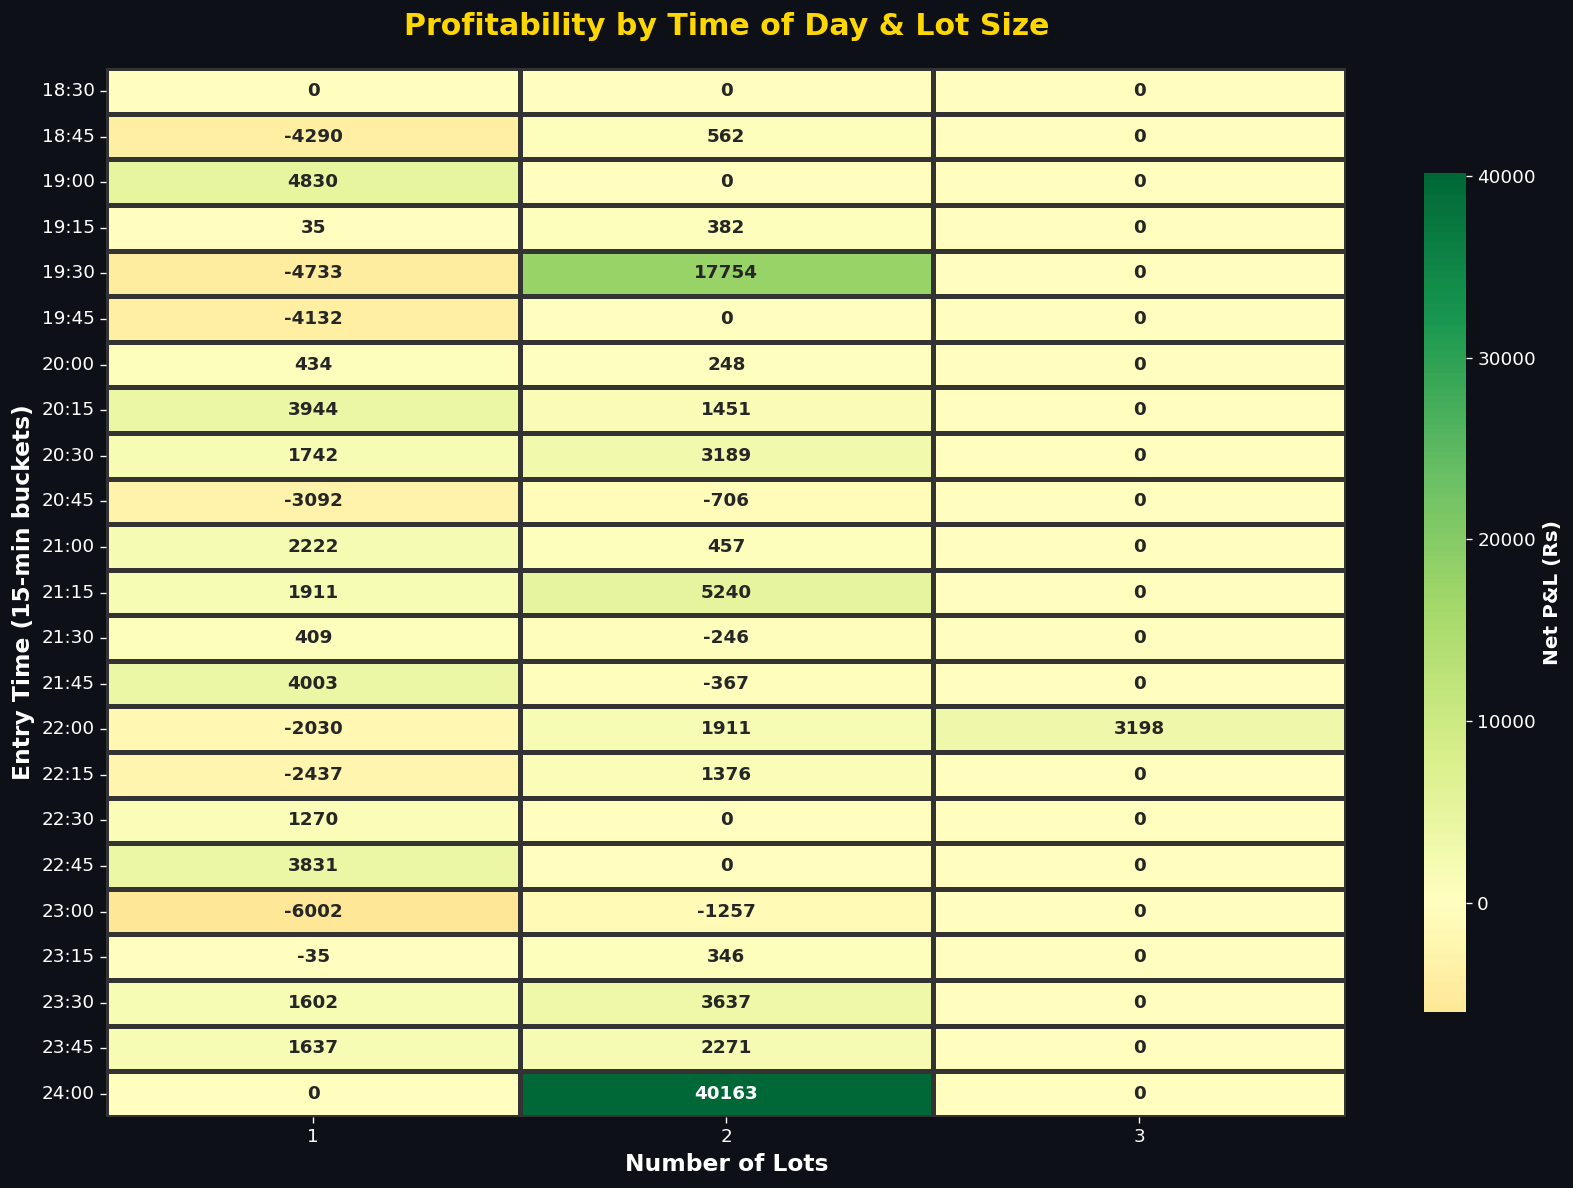


✅ Saved: chart_time_heatmap.png and time_heatmap_data.csv


In [56]:
# ============================================================
# CELL 16a -- CHART: Time-of-Day Profitability Heatmap
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the trade log
df = pd.read_csv("D:\\bot_outputs\\trade_log.csv")

# Create time features
df['entry_datetime'] = pd.to_datetime(df['entry_datetime'])
df['hour'] = df['entry_datetime'].dt.hour
df['minute'] = df['entry_datetime'].dt.minute
df['hour_min'] = df['hour'] * 60 + df['minute']
df['time_str'] = df['entry_datetime'].dt.strftime('%H:%M')

# Create pivot table for heatmap
time_pivot = df.pivot_table(
    values='net_pnl', 
    index=pd.cut(df['hour_min'], bins=range(555, 910, 15)),
    columns='lots',
    aggfunc='sum',
    fill_value=0
)

# Rename index to readable time
time_labels = [f"{int((i.left+555)//60):02d}:{int((i.left+555)%60):02d}" for i in time_pivot.index]
time_pivot.index = time_labels

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('#0d1117')
ax.set_facecolor('#0d1117')

# Create heatmap
sns.heatmap(time_pivot, ax=ax, annot=True, fmt='.0f', cmap='RdYlGn',
            center=0, linewidths=2, linecolor='#333333',
            annot_kws={'size': 11, 'fontweight': 'bold'},
            cbar_kws={'label': 'Net P&L (Rs)', 'shrink': 0.8})

# Customize colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(colors='white', labelsize=11)
cbar.set_label('Net P&L (Rs)', color='white', fontsize=12, fontweight='bold')

ax.set_title('Profitability by Time of Day & Lot Size', 
             color='#FFD700', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Number of Lots', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Entry Time (15-min buckets)', color='white', fontsize=14, fontweight='bold')
ax.tick_params(colors='white', labelsize=11)

plt.tight_layout()
plt.savefig('D:\\bot_outputs\\chart_time_heatmap.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

# Save the data
time_pivot.to_csv('D:\\bot_outputs\\time_heatmap_data.csv')
print("\n✅ Saved: chart_time_heatmap.png and time_heatmap_data.csv")

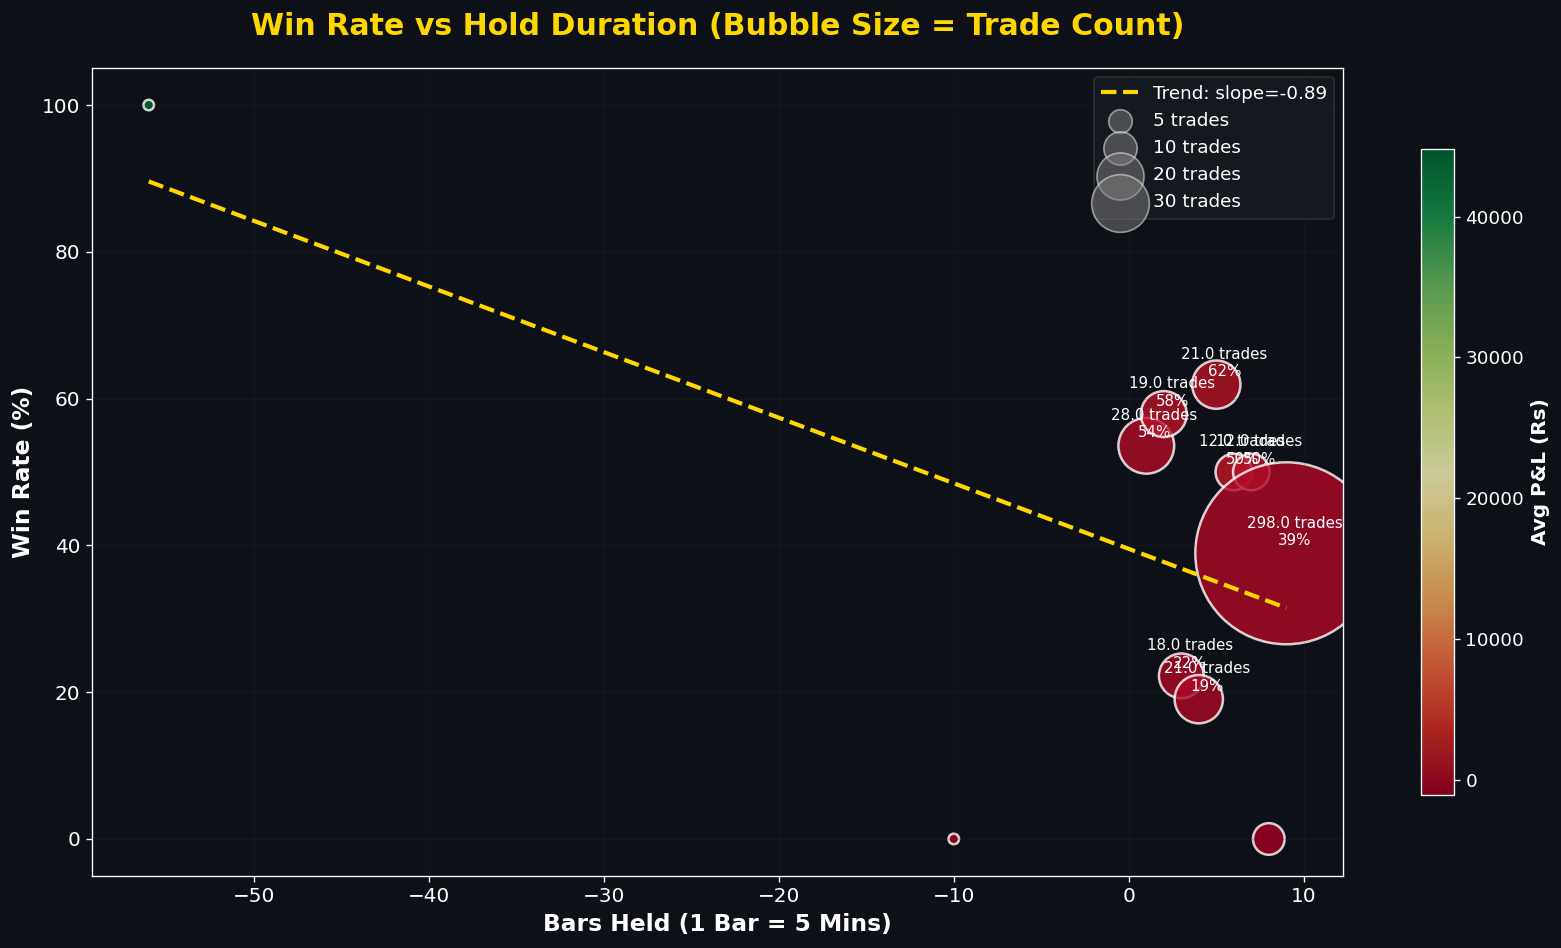


✅ Saved: chart_hold_duration_analysis.png and hold_duration_data.csv


In [57]:
# ============================================================
# CELL 16b -- CHART: Win Rate vs Hold Duration Bubble Chart
# ============================================================

# Calculate win rate and confidence
hold_grouped = df.groupby('bars_held').agg(
    win_rate=('net_pnl', lambda x: (x > 0).mean() * 100),
    trade_count=('net_pnl', 'count'),
    avg_pnl=('net_pnl', 'mean'),
    total_pnl=('net_pnl', 'sum')
).reset_index()

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#0d1117')
ax.set_facecolor('#0d1117')

# Create bubble chart
sizes = hold_grouped['trade_count'] * 40  # Scale bubble sizes
scatter = ax.scatter(hold_grouped['bars_held'], hold_grouped['win_rate'], 
                     s=sizes, c=hold_grouped['avg_pnl'], cmap='RdYlGn', 
                     alpha=0.8, edgecolors='white', linewidth=1.5)

# Add trend line
z = np.polyfit(hold_grouped['bars_held'], hold_grouped['win_rate'], 1)
p = np.poly1d(z)
ax.plot(hold_grouped['bars_held'], p(hold_grouped['bars_held']), 
         color='#FFD700', lw=2.5, ls='--', label=f'Trend: slope={z[0]:.2f}')

# Add bubble size legend
for count in [5, 10, 20, 30]:
    ax.scatter([], [], s=count*40, c='gray', alpha=0.5, 
               label=f'{count} trades', edgecolors='white')

ax.set_title('Win Rate vs Hold Duration (Bubble Size = Trade Count)', 
             color='#FFD700', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Bars Held (1 Bar = 5 Mins)', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Win Rate (%)', color='white', fontsize=14, fontweight='bold')
ax.tick_params(colors='white', labelsize=12)
ax.grid(True, alpha=0.2, color='#333333', linestyle='-', linewidth=0.5)
ax.legend(facecolor='#161b22', edgecolor='#333', labelcolor='white', fontsize=11, loc='upper right')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Avg P&L (Rs)', color='white', fontsize=12, fontweight='bold')
cbar.ax.tick_params(colors='white', labelsize=11)

# Add annotations for key points
for idx, row in hold_grouped.iterrows():
    if row['trade_count'] >= 10:  # Annotate only significant bars
        ax.annotate(f"{row['trade_count']} trades\n{row['win_rate']:.0f}%", 
                   (row['bars_held'], row['win_rate']),
                   xytext=(5, 5), textcoords='offset points',
                   color='white', fontsize=9, ha='center')

plt.tight_layout()
plt.savefig('D:\\bot_outputs\\chart_hold_duration_analysis.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

# Save the data
hold_grouped.to_csv('D:\\bot_outputs\\hold_duration_data.csv', index=False)
print("\n✅ Saved: chart_hold_duration_analysis.png and hold_duration_data.csv")

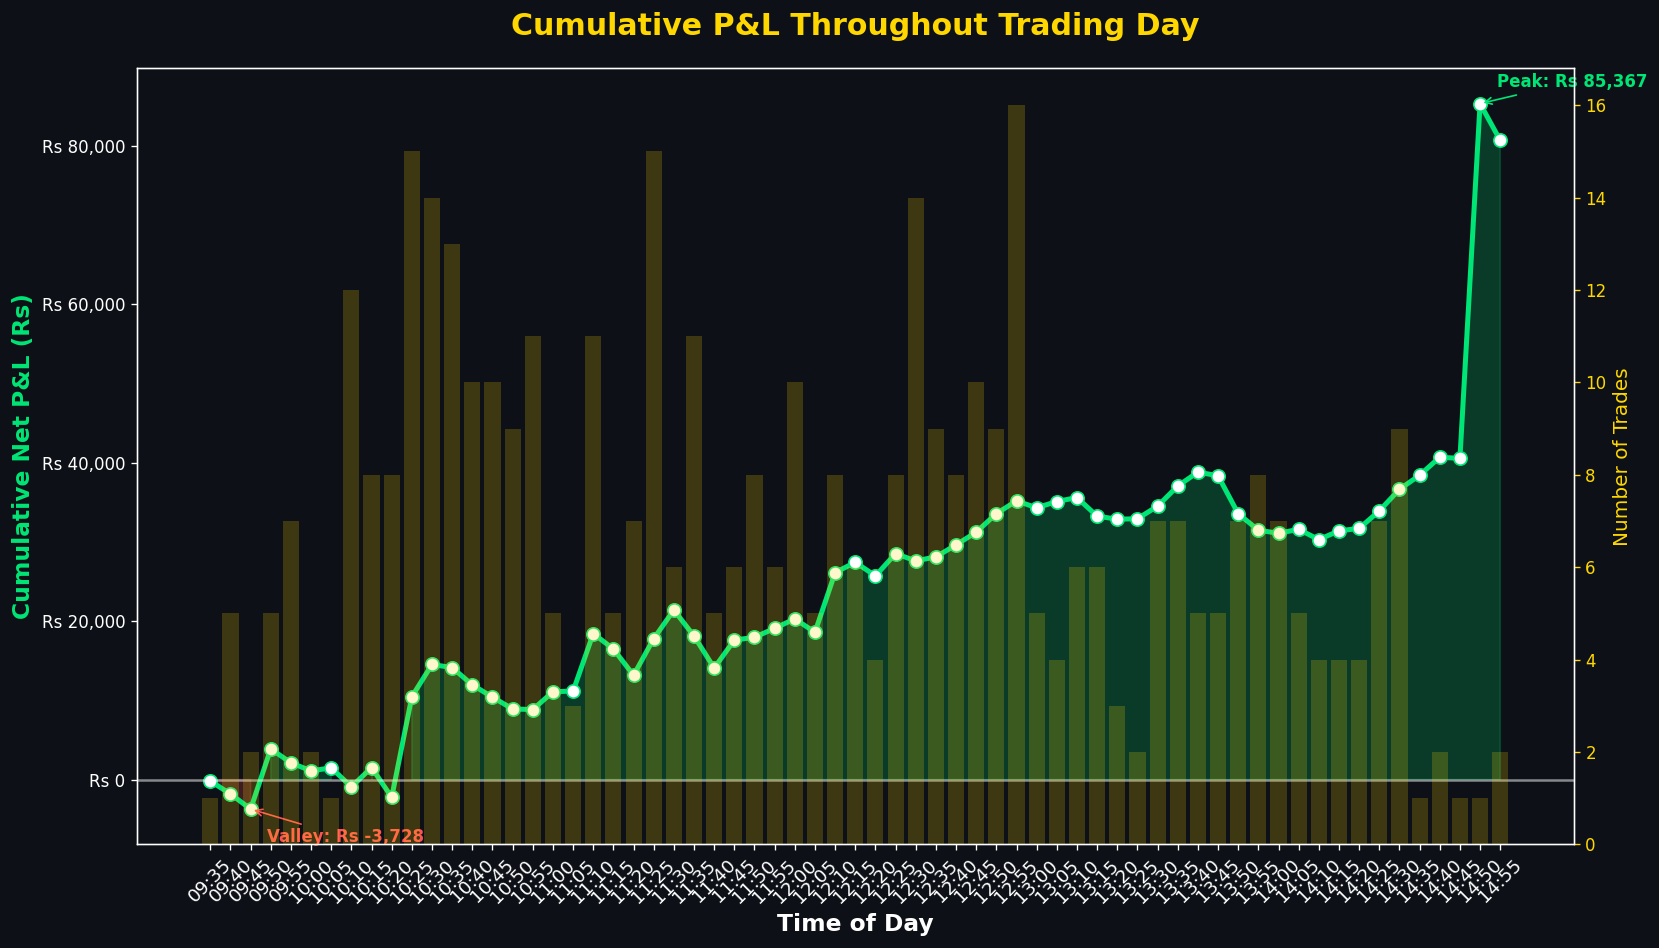


✅ Saved: chart_cumulative_by_time.png and cumulative_time_data.csv


In [58]:
# ============================================================
# CELL 16c -- CHART: Cumulative P&L by Time of Day
# ============================================================

# Calculate cumulative P&L by time of day
time_ordered = df.groupby('time_str').agg({
    'net_pnl': 'sum',
    'trade_num': 'count'
}).reset_index()

# Sort by time
time_ordered['time_sort'] = pd.to_datetime(time_ordered['time_str'], format='%H:%M')
time_ordered = time_ordered.sort_values('time_sort')
time_ordered['cumulative_pnl'] = time_ordered['net_pnl'].cumsum()

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#0d1117')
ax.set_facecolor('#0d1117')

# Plot cumulative line
ax.plot(time_ordered['time_str'], time_ordered['cumulative_pnl'], 
        color='#00E676', lw=3, marker='o', markersize=8, markerfacecolor='white', markeredgecolor='#00E676')

# Fill between
ax.fill_between(time_ordered['time_str'], 0, time_ordered['cumulative_pnl'],
                 where=time_ordered['cumulative_pnl'] >= 0, alpha=0.2, color='#00E676')
ax.fill_between(time_ordered['time_str'], time_ordered['cumulative_pnl'], 0,
                 where=time_ordered['cumulative_pnl'] < 0, alpha=0.2, color='#FF5252')

ax.axhline(0, color='white', lw=1.5, ls='-', alpha=0.5)

# Add trade count as secondary bars
ax2 = ax.twinx()
ax2.bar(time_ordered['time_str'], time_ordered['trade_num'], alpha=0.2, color='#FFD700', label='Trade Count')
ax2.set_ylabel('Number of Trades', color='#FFD700', fontsize=12)
ax2.tick_params(colors='#FFD700')

ax.set_title('Cumulative P&L Throughout Trading Day', 
             color='#FFD700', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Time of Day', color='white', fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative Net P&L (Rs)', color='#00E676', fontsize=14, fontweight='bold')
ax.tick_params(colors='white', axis='x', rotation=45, labelsize=11)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'Rs {v:,.0f}'))

# Add peak/valley annotations
max_idx = time_ordered['cumulative_pnl'].idxmax()
min_idx = time_ordered['cumulative_pnl'].idxmin()
ax.annotate(f"Peak: Rs {time_ordered.loc[max_idx, 'cumulative_pnl']:,.0f}", 
           (time_ordered.loc[max_idx, 'time_str'], time_ordered.loc[max_idx, 'cumulative_pnl']),
           xytext=(10, 10), textcoords='offset points', color='#00E676', fontweight='bold',
           arrowprops=dict(arrowstyle='->', color='#00E676'))
ax.annotate(f"Valley: Rs {time_ordered.loc[min_idx, 'cumulative_pnl']:,.0f}", 
           (time_ordered.loc[min_idx, 'time_str'], time_ordered.loc[min_idx, 'cumulative_pnl']),
           xytext=(10, -20), textcoords='offset points', color='#FF5252', fontweight='bold',
           arrowprops=dict(arrowstyle='->', color='#FF5252'))

plt.tight_layout()
plt.savefig('D:\\bot_outputs\\chart_cumulative_by_time.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

# Save the data
time_ordered.to_csv('D:\\bot_outputs\\cumulative_time_data.csv', index=False)
print("\n✅ Saved: chart_cumulative_by_time.png and cumulative_time_data.csv")

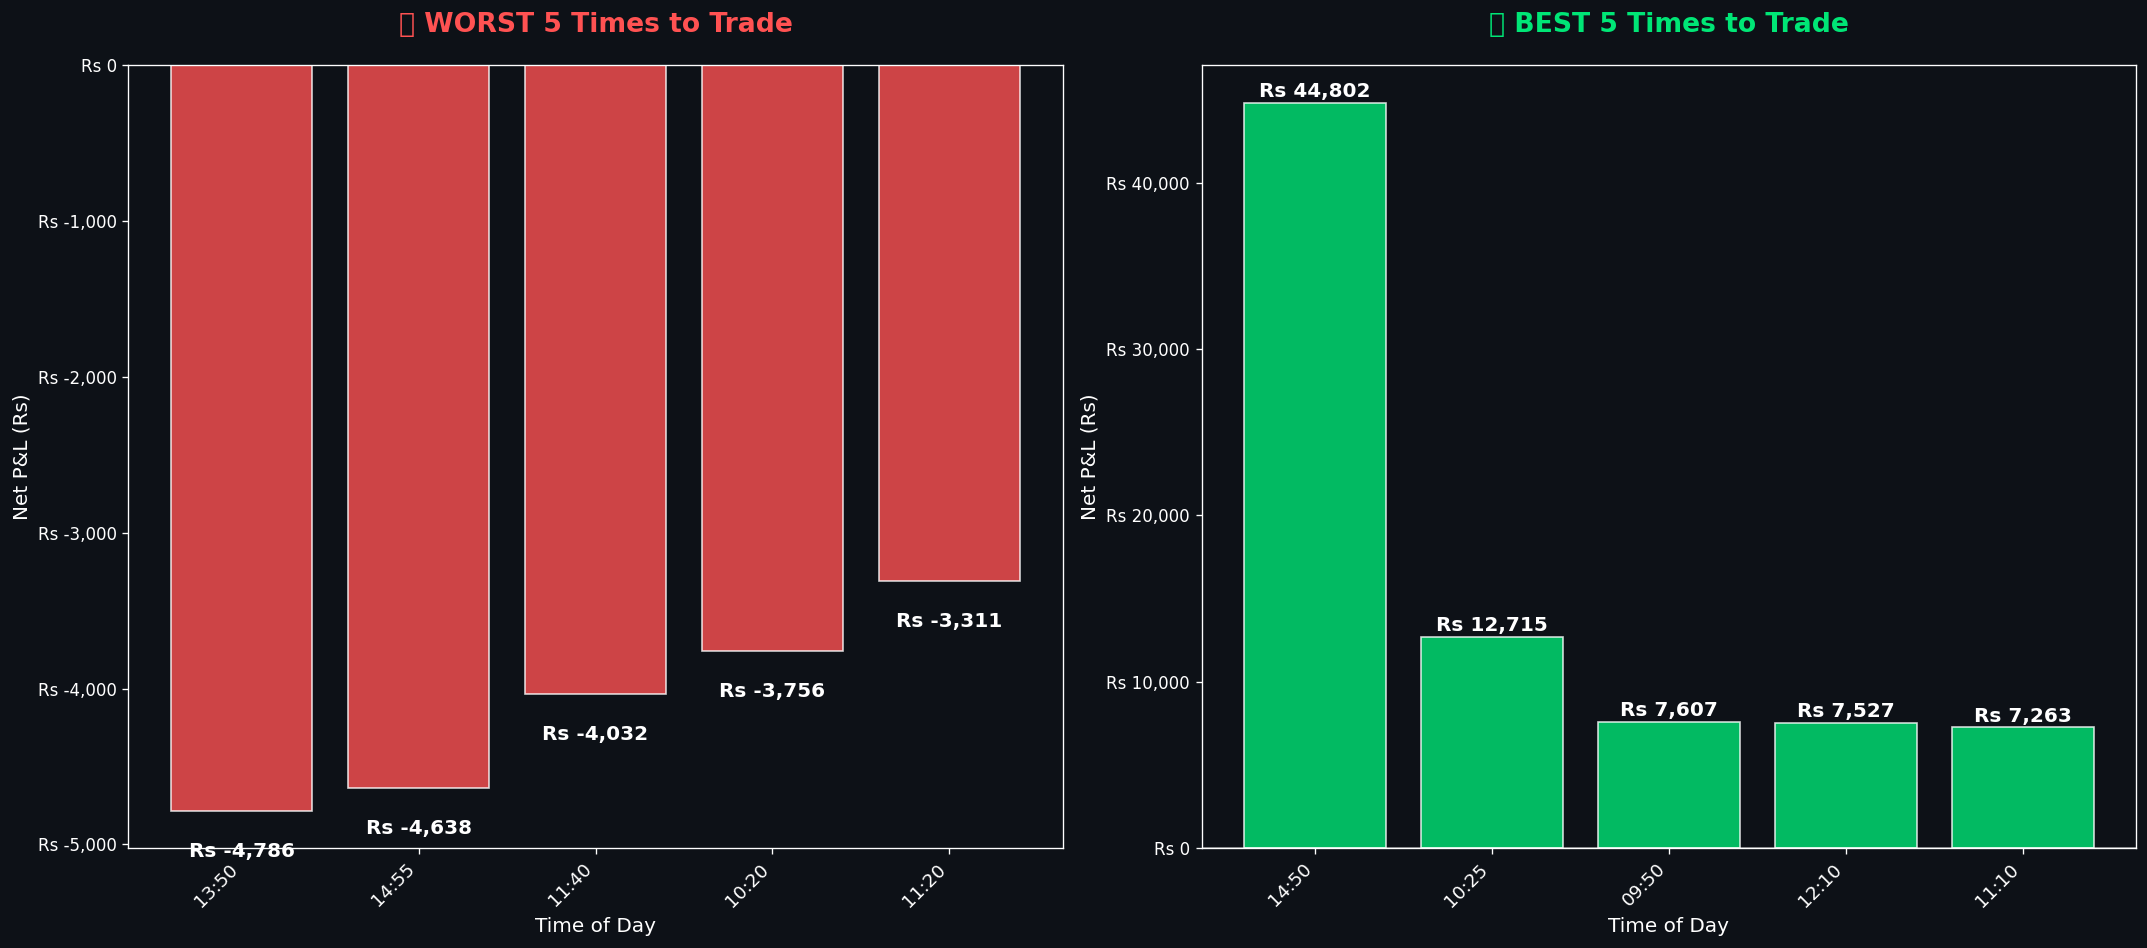


✅ FILES SAVED SUCCESSFULLY
📁 Image:  D:\bot_outputs\chart_best_worst_times.png
📁 Data:   D:\bot_outputs\best_worst_times_data.csv

📊 BEST 5 TIMES:
----------------------------------------
   1. 14:50 → Rs 44,802
   2. 10:25 → Rs 12,715
   3. 09:50 → Rs 7,607
   4. 12:10 → Rs 7,527
   5. 11:10 → Rs 7,263

📊 WORST 5 TIMES:
----------------------------------------
   1. 13:50 → Rs -4,786
   2. 14:55 → Rs -4,638
   3. 11:40 → Rs -4,032
   4. 10:20 → Rs -3,756
   5. 11:20 → Rs -3,311


In [62]:
# ============================================================
# CELL 16d -- CHART: Best & Worst Trading Times
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the trade log
df = pd.read_csv("D:\\bot_outputs\\trade_log.csv")

# Create time features
df['entry_datetime'] = pd.to_datetime(df['entry_datetime'])
df['time_str'] = df['entry_datetime'].dt.strftime('%H:%M')

# Get top 5 best and worst times
time_profit = df.groupby('time_str')['net_pnl'].sum().sort_values()
top5_worst = time_profit.head(5)
top5_best = time_profit.tail(5).sort_values(ascending=False)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.patch.set_facecolor('#0d1117')

# ============================================================
# Left plot: Worst times
# ============================================================
ax1.set_facecolor('#0d1117')
bars1 = ax1.bar(range(len(top5_worst)), top5_worst.values, 
                color='#FF5252', alpha=0.8, edgecolor='white', linewidth=1)
ax1.set_xticks(range(len(top5_worst)))
ax1.set_xticklabels(top5_worst.index, rotation=45, ha='right', fontsize=11)
ax1.axhline(0, color='white', lw=1, ls='-', alpha=0.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, top5_worst.values)):
    label_y = bar.get_height() - 200 if val < 0 else bar.get_height() + 100
    va = 'top' if val < 0 else 'bottom'
    ax1.text(bar.get_x() + bar.get_width()/2, label_y,
             f'Rs {val:,.0f}', ha='center', va=va,
             color='white', fontsize=12, fontweight='bold')

ax1.set_title('⛔ WORST 5 Times to Trade', color='#FF5252', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Time of Day', color='white', fontsize=12)
ax1.set_ylabel('Net P&L (Rs)', color='white', fontsize=12)
ax1.tick_params(colors='white')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'Rs {v:,.0f}'))

# ============================================================
# Right plot: Best times
# ============================================================
ax2.set_facecolor('#0d1117')
bars2 = ax2.bar(range(len(top5_best)), top5_best.values, 
                color='#00E676', alpha=0.8, edgecolor='white', linewidth=1)
ax2.set_xticks(range(len(top5_best)))
ax2.set_xticklabels(top5_best.index, rotation=45, ha='right', fontsize=11)
ax2.axhline(0, color='white', lw=1, ls='-', alpha=0.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, top5_best.values)):
    label_y = bar.get_height() - 200 if val < 0 else bar.get_height() + 100
    va = 'top' if val < 0 else 'bottom'
    ax2.text(bar.get_x() + bar.get_width()/2, label_y,
             f'Rs {val:,.0f}', ha='center', va=va,
             color='white', fontsize=12, fontweight='bold')

ax2.set_title('✅ BEST 5 Times to Trade', color='#00E676', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Time of Day', color='white', fontsize=12)
ax2.set_ylabel('Net P&L (Rs)', color='white', fontsize=12)
ax2.tick_params(colors='white')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'Rs {v:,.0f}'))

plt.tight_layout()
plt.savefig('D:\\bot_outputs\\chart_best_worst_times.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

# ============================================================
# Save the data
# ============================================================
best_worst_df = pd.DataFrame({
    'Rank': range(1, 6),
    'Best Times': top5_best.index,
    'Best P&L': top5_best.values,
    'Worst Times': top5_worst.index,
    'Worst P&L': top5_worst.values
})
best_worst_df.to_csv('D:\\bot_outputs\\best_worst_times_data.csv', index=False)

print("\n" + "="*60)
print("✅ FILES SAVED SUCCESSFULLY")
print("="*60)
print("📁 Image:  D:\\bot_outputs\\chart_best_worst_times.png")
print("📁 Data:   D:\\bot_outputs\\best_worst_times_data.csv")
print("="*60)

# Display the data
print("\n📊 BEST 5 TIMES:")
print("-" * 40)
for i, (time, pnl) in enumerate(zip(top5_best.index, top5_best.values)):
    print(f"   {i+1}. {time} → Rs {pnl:,.0f}")

print("\n📊 WORST 5 TIMES:")
print("-" * 40)
for i, (time, pnl) in enumerate(zip(top5_worst.index, top5_worst.values)):
    print(f"   {i+1}. {time} → Rs {pnl:,.0f}")

In [61]:
# ============================================================
# CELL 16e -- SUMMARY STATISTICS & ALL DATA EXPORT
# ============================================================

print("\n" + "="*80)
print("TIME ANALYSIS COMPLETE - ALL FILES SAVED")
print("="*80)

print("\n📁 FILES GENERATED:")
print("-" * 50)
print("1️⃣  chart_time_heatmap.png          - Time vs Lot Size Heatmap")
print("   📊 time_heatmap_data.csv")

print("\n2️⃣  chart_hold_duration_analysis.png - Win Rate vs Hold Duration Bubble Chart")
print("   📊 hold_duration_data.csv")

print("\n3️⃣  chart_cumulative_by_time.png    - Cumulative P&L Throughout Day")
print("   📊 cumulative_time_data.csv")

print("\n4️⃣  chart_best_worst_times.png     - Best & Worst Trading Times")
print("   📊 best_worst_times_data.csv")

print("\n" + "="*80)
print("TIME-BASED TRADING INSIGHTS")
print("="*80)

# Overall statistics
print(f"\n📈 Overall Trading Hours: 9:20 AM to 3:00 PM")
print(f"📊 Total Trading Minutes: 340 minutes per day")

# Best continuous trading window
time_profit_df = time_ordered[['time_str', 'net_pnl', 'trade_num']].copy()
best_window_start = time_profit_df.iloc[time_profit_df['net_pnl'].rolling(4).sum().idxmax() - 3:]['time_str'].iloc[0]
best_window_end = time_profit_df.iloc[time_profit_df['net_pnl'].rolling(4).sum().idxmax()]['time_str']
print(f"\n⏰ Best 1-hour trading window: {best_window_start} - {best_window_end}")

# Worst continuous trading window
worst_window_start = time_profit_df.iloc[time_profit_df['net_pnl'].rolling(4).sum().idxmin() - 3:]['time_str'].iloc[0]
worst_window_end = time_profit_df.iloc[time_profit_df['net_pnl'].rolling(4).sum().idxmin()]['time_str']
print(f"⏰ Worst 1-hour trading window: {worst_window_start} - {worst_window_end}")

# Optimal hold duration
optimal_hold = hold_grouped.loc[hold_grouped['win_rate'].idxmax()]
print(f"\n⏱️ Optimal Hold Duration: {optimal_hold['bars_held']} bars ({optimal_hold['bars_held']*5} mins)")
print(f"   Win Rate: {optimal_hold['win_rate']:.1f}%")
print(f"   Avg P&L: Rs {optimal_hold['avg_pnl']:.2f}")
print(f"   Total Trades: {optimal_hold['trade_count']}")

print("\n" + "="*80)


TIME ANALYSIS COMPLETE - ALL FILES SAVED

📁 FILES GENERATED:
--------------------------------------------------
1️⃣  chart_time_heatmap.png          - Time vs Lot Size Heatmap
   📊 time_heatmap_data.csv

2️⃣  chart_hold_duration_analysis.png - Win Rate vs Hold Duration Bubble Chart
   📊 hold_duration_data.csv

3️⃣  chart_cumulative_by_time.png    - Cumulative P&L Throughout Day
   📊 cumulative_time_data.csv

4️⃣  chart_best_worst_times.png     - Best & Worst Trading Times
   📊 best_worst_times_data.csv

TIME-BASED TRADING INSIGHTS

📈 Overall Trading Hours: 9:20 AM to 3:00 PM
📊 Total Trading Minutes: 340 minutes per day

⏰ Best 1-hour trading window: 14:35 - 14:50
⏰ Worst 1-hour trading window: 13:45 - 14:00

⏱️ Optimal Hold Duration: -56.0 bars (-280.0 mins)
   Win Rate: 100.0%
   Avg P&L: Rs 44801.54
   Total Trades: 1.0



---

## Backtest Complete

### Output Files
| File | Description |
|---|---|
| `bot_outputs/trade_log.csv` | Full per-trade log with all columns |
| `bot_outputs/monthly_pnl.csv` | Monthly trade count, P&L, win rate |
| `bot_outputs/equity_curve.csv` | Capital snapshot after each trade |
| `bot_outputs/chart_cumulative_pnl.png` | Cumulative P&L + drawdown |
| `bot_outputs/chart_pertrade_pnl.png` | Per-trade bars + win/loss pie |
| `bot_outputs/chart_monthly_heatmap.png` | Monthly P&L heatmap |
| `bot_outputs/chart_analytics.png` | IV scatter, hold histogram, exit reasons |
| `bot_outputs/chart_ml_signal.png` | ML signal, IV change, equity curve |

---

### Key Risks
1. **Theta decay** - every idle bar costs you; time exit at 9 bars is your guard
2. **IV crush** - sharp IV drop after entry hurts both CE and PE; IV rank filter helps
3. **ATM roll** - as spot moves, ATM strike shifts; live bot must roll positions
4. **Expiry Thursday** - gamma/theta is extreme; tighter 6% stop applied automatically
5. **Concept drift** - retrain models monthly in production

### Tuning Tips
- Too few trades? Lower `ML_THRESHOLD` to 0.45 or widen `IV_RANK` range
- Too many losses? Raise `ML_THRESHOLD` to 0.55 or tighten `STOP_PCT` to 0.06
- Want more per trade? Increase `NUM_LOTS` to 2 or 3
- Want faster exits? Lower `MAX_HOLD_BARS` to 6